# Apply Deep Learning Models

On selected examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy.constants import au, R_sun, R_earth, R_jup

from astropy import units as u
from astropy.constants import au, R_sun, R_jup


In [2]:
from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [3]:
import time


In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

### Utils

In [5]:
def get_example(index, folder, data, only_info = False):
    
    query_index = data[data["index"] == index]
    local_filename = query_index[query_index["view"] == "Local"]["filename"].values[0]
    global_filename = query_index[query_index["view"] == "Global"]["filename"].values[0]
    
    
    info = {
        'target': data[data["index"] == index]['target'].values[0],
        'satellite': data[data["index"] == index]['satellite'].values[0],
        'label': data[data["index"] == index]['label'].values[0],
        'r_s': query_index["star_radius"].values[0],
        'r_p': query_index["k"].values[0] * query_index["star_radius"].values[0] * R_sun /R_jup ,
        'k': query_index["k"].values[0],
        'p': query_index["period"].values[0],
        'a_os': query_index["aos"].values[0],
        'i': query_index["i"].values[0],
        't_0': query_index["t0"].values[0]
    }
    
    if (only_info):
        return info
    else:
        data_global = np.load(f"{folder}/{global_filename}")
        data_local = np.load(f"{folder}/{local_filename}")

        return data_local, data_global, info
    

## Load data

In [6]:
# load
folder = 'csv'

data_train_full = pd.read_csv(f'{folder}/data_train_full.csv')
data_test_without_label = pd.read_csv(f'{folder}/data_test_without_label.csv')

In [7]:
print("n examples train + validation: ", data_train_full[data_train_full["view"] == "Global"].shape[0])
print("n examples test: ", data_test_without_label[data_test_without_label["view"] == "Global"].shape[0])

n examples train + validation:  11641
n examples test:  1294


In [8]:
#data_train_full[data_train_full["view"] == "Global"]

In [9]:
data_train_full_util_ = data_train_full.copy() # only local and global view
data_train_full_util = data_train_full_util_[(data_train_full_util_["view"] == "Local")|(data_train_full_util_["view"] == "Global")]
data_train_full_util.reset_index(drop=True)

,target,satellite,label,index,filename,view,period,t0,star_radius,k,aos,i,e,w,ldcs_1,ldcs_2,n_points_transit
0,HD102249,BHr,PC,0,0_global_HD102249_BHr.npy,Global,2.485603,1506.040641,3.47246,0.032584,3.100417,1.541473,0.0,0.0,0.32,0.07,2076
1,HD102249,BHr,PC,0,0_local_HD102249_BHr.npy,Local,2.485603,1506.040641,3.47246,0.032584,3.100417,1.541473,0.0,0.0,0.32,0.07,2076
2,HD102249,BHr,PC,19,19_global_HD102249_BHr.npy,Global,4.751788,1457.811459,3.47246,0.038840,4.774851,1.539857,0.0,0.0,0.31,0.09,1487
3,HD102249,BHr,PC,19,19_local_HD102249_BHr.npy,Local,4.751788,1457.811459,3.47246,0.038840,4.774851,1.539857,0.0,0.0,0.31,0.09,1487
4,HD102249,BHr,PC,38,38_global_HD102249_BHr.npy,Global,3.922281,1453.970144,3.47246,0.053293,4.201768,1.537861,0.0,0.0,0.36,0.11,2577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23277,HD93194,BHr,NOT_PC,21217,21217_local_HD93194_BHr.npy,Local,2.298671,3306.555023,3.40000,0.053545,2.987705,1.551501,0.0,0.0,NaN,NaN,4724
23278,HD93194,BHr,NOT_PC,21219,21219_global_HD93194_BHr.npy,Global,2.154236,3303.658707,3.40000,0.032684,2.861204,1.565683,0.0,0.0,NaN,NaN,4724
23279,HD93194,BHr,NOT_PC,21219,21219_local_HD93194_BHr.npy,Local,2.154236,3303.658707,3.40000,0.032684,2.861204,1.565683,0.0,0.0,NaN,NaN,4724
23280,HD93194,BHr,NOT_PC,21221,21221_global_HD93194_BHr.npy,Global,3.516998,3334.659985,3.40000,0.056737,3.967053,1.549809,0.0,0.0,NaN,NaN,4724


In [10]:
print(data_train_full_util.shape[0]//2) # check consistency

data_train_full_util.head()

11641


,target,satellite,label,index,filename,view,period,t0,star_radius,k,aos,i,e,w,ldcs_1,ldcs_2,n_points_transit
2,HD102249,BHr,PC,0,0_global_HD102249_BHr.npy,Global,2.485603,1506.040641,3.47246,0.032584,3.100417,1.541473,0.0,0.0,0.32,0.07,2076
3,HD102249,BHr,PC,0,0_local_HD102249_BHr.npy,Local,2.485603,1506.040641,3.47246,0.032584,3.100417,1.541473,0.0,0.0,0.32,0.07,2076
6,HD102249,BHr,PC,19,19_global_HD102249_BHr.npy,Global,4.751788,1457.811459,3.47246,0.038840,4.774851,1.539857,0.0,0.0,0.31,0.09,1487
7,HD102249,BHr,PC,19,19_local_HD102249_BHr.npy,Local,4.751788,1457.811459,3.47246,0.038840,4.774851,1.539857,0.0,0.0,0.31,0.09,1487
10,HD102249,BHr,PC,38,38_global_HD102249_BHr.npy,Global,3.922281,1453.970144,3.47246,0.053293,4.201768,1.537861,0.0,0.0,0.36,0.11,2577


## Exploratory

In [11]:
data_train_full_util.columns

Index(['target', 'satellite', 'label', 'index', 'filename', 'view', 'period',
       't0', 'star_radius', 'k', 'aos', 'i', 'e', 'w', 'ldcs_1', 'ldcs_2',
       'n_points_transit'],
      dtype='object')

In [ ]:
# k = rp/rs
# k*rs = rp

data_train_full_util["planet_radius"] = data_train_full_util["star_radius"]*data_train_full_util["k"]*R_sun/R_jup



In [13]:
data_train_full_util.columns

Index(['target', 'satellite', 'label', 'index', 'filename', 'view', 'period',
       't0', 'star_radius', 'k', 'aos', 'i', 'e', 'w', 'ldcs_1', 'ldcs_2',
       'n_points_transit', 'planet_radius'],
      dtype='object')

In [14]:
print(np.min(data_train_full_util[data_train_full_util["view"] == "Global"]["aos"]))
print(np.max(data_train_full_util[data_train_full_util["view"] == "Global"]["aos"]))

1.53273278158495
15.975197418187994


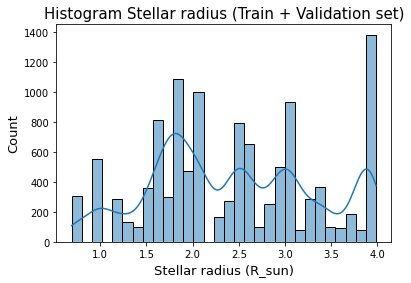

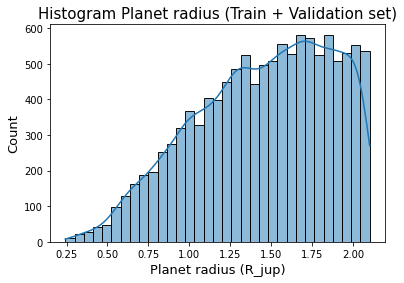

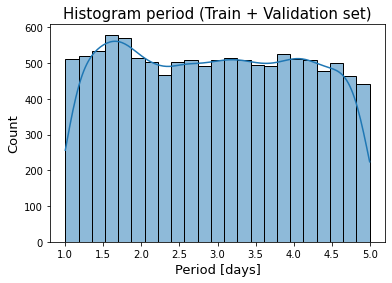

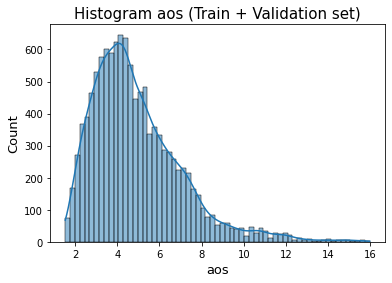

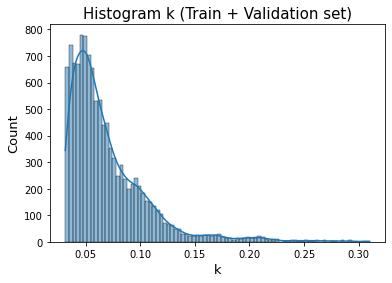

In [15]:
list_radius = data_train_full_util[data_train_full_util["view"] == "Global"]["star_radius"]
list_period = data_train_full_util[data_train_full_util["view"] == "Global"]["period"]
list_aos = data_train_full_util[data_train_full_util["view"] == "Global"]["aos"]
list_k = data_train_full_util[data_train_full_util["view"] == "Global"]["k"]
list_radius_planet = data_train_full_util[data_train_full_util["view"] == "Global"]["planet_radius"]

plt.title(f"Histogram Stellar radius (Train + Validation set)", fontsize = 15)
sns.histplot(data=list_radius, kde=True)
plt.xlabel("Stellar radius (R_sun)", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()

plt.title(f"Histogram Planet radius (Train + Validation set)", fontsize = 15)
sns.histplot(data=list_radius_planet, kde=True)
plt.xlabel("Planet radius (R_jup)", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()

plt.title(f"Histogram period (Train + Validation set)", fontsize = 15)
sns.histplot(data=list_period, kde=True)
plt.xlabel("Period [days]", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()

plt.title(f"Histogram aos (Train + Validation set)", fontsize = 15)
sns.histplot(data=list_aos, kde=True)
plt.xlabel("aos", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()

plt.title(f"Histogram k (Train + Validation set)", fontsize = 15)
sns.histplot(data=list_k, kde=True)
plt.xlabel("k", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()

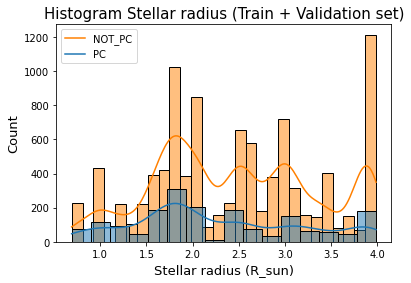

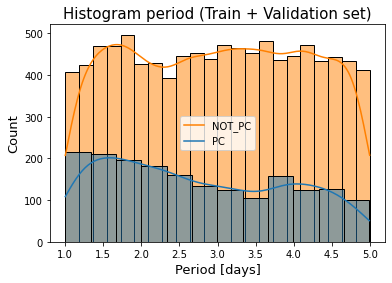

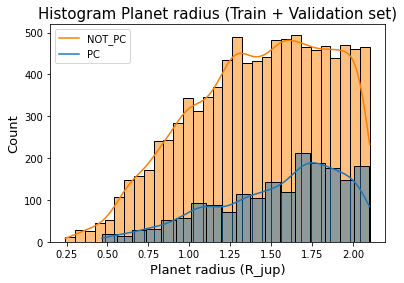

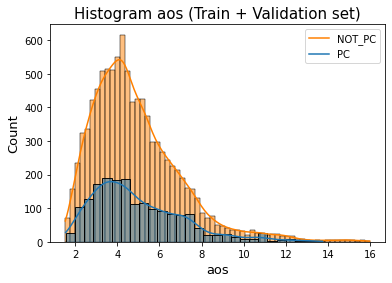

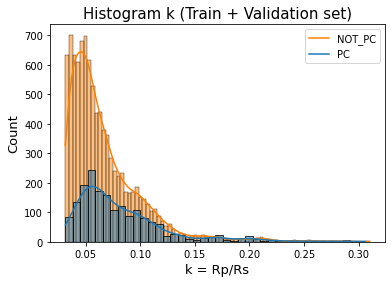

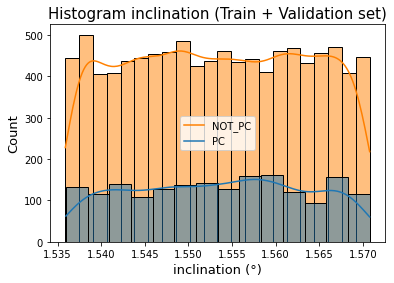

In [16]:


list_radius_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "PC")]["star_radius"]
list_radius_NOT_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "NOT_PC")]["star_radius"]

list_period_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "PC")]["period"]
list_period_NOT_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "NOT_PC")]["period"]

list_aos_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "PC")]["aos"]
list_aos_NOT_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "NOT_PC")]["aos"]

list_k_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "PC")]["k"]
list_k_NOT_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "NOT_PC")]["k"]

list_radius_planet_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "PC")]["planet_radius"]
list_radius_planet_NOT_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "NOT_PC")]["planet_radius"]

list_inclination_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "PC")]["i"]
list_inclination_NOT_PC = data_train_full_util[(data_train_full_util["view"] == "Global")&(data_train_full_util["label"] == "NOT_PC")]["i"]


plt.title(f"Histogram Stellar radius (Train + Validation set)", fontsize = 15)
sns.histplot(data=list_radius_NOT_PC, kde=True, color = '#ff8000')
sns.histplot(data=list_radius_PC, kde=True)
plt.legend(labels=['NOT_PC', 'PC'])
plt.xlabel("Stellar radius (R_sun)", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()


plt.title(f"Histogram period (Train + Validation set)", fontsize = 15)
sns.histplot(data=list_period_NOT_PC, kde=True, color = '#ff8000')
sns.histplot(data=list_period_PC, kde=True)
plt.legend(labels=['NOT_PC', 'PC'])

plt.xlabel("Period [days]", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()

plt.title(f"Histogram Planet radius (Train + Validation set)", fontsize = 15)
sns.histplot(data=list_radius_planet_NOT_PC, kde=True, color = '#ff8000')
sns.histplot(data=list_radius_planet_PC, kde=True)
plt.legend(labels=['NOT_PC', 'PC'])
plt.xlabel("Planet radius (R_jup)", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()

plt.title(f"Histogram aos (Train + Validation set)", fontsize = 15)
sns.histplot(data=list_aos_NOT_PC, kde=True, color = '#ff8000')
sns.histplot(data=list_aos_PC, kde=True)
plt.legend(labels=['NOT_PC', 'PC'])
plt.xlabel("aos", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()

plt.title(f"Histogram k (Train + Validation set)", fontsize = 15)
sns.histplot(data=list_k_NOT_PC, kde=True, color = '#ff8000')
sns.histplot(data=list_k_PC, kde=True)
plt.legend(labels=['NOT_PC', 'PC'])
plt.xlabel("k = Rp/Rs", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()


plt.title(f"Histogram inclination (Train + Validation set)", fontsize = 15)
sns.histplot(data=list_inclination_NOT_PC, kde=True, color = '#ff8000')
sns.histplot(data=list_inclination_PC, kde=True)
plt.legend(labels=['NOT_PC', 'PC'])
plt.xlabel("inclination (°)", fontsize = 13)
plt.ylabel("Count", fontsize = 13)
plt.show()


In [17]:
### 
print("Min period [days]: ", np.min(list_period))
print("Max period [days]: ", np.max(list_period))


Min period [days]:  1.0001542075502203
Max period [days]:  4.998459414034299


In [18]:
'''
fig, ax = plt.subplots(figsize=(5,5))

kd = data_train_full_util[data_train_full_util["view"]=="Global"].groupby(['label']).size().reset_index(name='counts')
print(kd)

sns.barplot(data=kd, y='counts', x='label', palette="Blues_d", ax=ax)
ax.set_title('Occurrences of each class (Train + Validation set)')
plt.show()

fig, ax = plt.subplots(figsize=(5,5))

kd = data_train[data_train["view"]=="Global"].groupby(['label']).size().reset_index(name='counts')
print(kd)

sns.barplot(data=kd, y='counts', x='label', palette="Blues_d", ax=ax)
ax.set_title('Occurrences of each class (Train set)')
plt.show()

fig, ax = plt.subplots(figsize=(5,5))

kd = data_validation[data_validation["view"]=="Global"].groupby(['label']).size().reset_index(name='counts')
print(kd)

sns.barplot(data=kd, y='counts', x='label', palette="Blues_d", ax=ax)
ax.set_title('Occurrences of each class (Validation set)')
plt.show()
'''

'\nfig, ax = plt.subplots(figsize=(5,5))\n\nkd = data_train_full_util[data_train_full_util["view"]=="Global"].groupby([\'label\']).size().reset_index(name=\'counts\')\nprint(kd)\n\nsns.barplot(data=kd, y=\'counts\', x=\'label\', palette="Blues_d", ax=ax)\nax.set_title(\'Occurrences of each class (Train + Validation set)\')\nplt.show()\n\nfig, ax = plt.subplots(figsize=(5,5))\n\nkd = data_train[data_train["view"]=="Global"].groupby([\'label\']).size().reset_index(name=\'counts\')\nprint(kd)\n\nsns.barplot(data=kd, y=\'counts\', x=\'label\', palette="Blues_d", ax=ax)\nax.set_title(\'Occurrences of each class (Train set)\')\nplt.show()\n\nfig, ax = plt.subplots(figsize=(5,5))\n\nkd = data_validation[data_validation["view"]=="Global"].groupby([\'label\']).size().reset_index(name=\'counts\')\nprint(kd)\n\nsns.barplot(data=kd, y=\'counts\', x=\'label\', palette="Blues_d", ax=ax)\nax.set_title(\'Occurrences of each class (Validation set)\')\nplt.show()\n'

## Astronet (keras)

In [19]:
def get_model_CNN1D(name, input_shape, activation_func, cnn_num_blocks, cnn_initial_num_filters, cnn_block_filter_factor, 
                    cnn_block_size, cnn_kernel_size, convolution_padding, pool_size, pool_strides):
    
    input = keras.Input(shape = input_shape, name=f'Input_{name}') # input
    x = input
    for i in range(cnn_num_blocks):
        num_filters = int(cnn_initial_num_filters *
                          cnn_block_filter_factor**i)
        print(f"block_{i+1}")
        for j in range(cnn_block_size):
            x = keras.layers.Conv1D(filters = num_filters, kernel_size = int(cnn_kernel_size), 
                                    padding=convolution_padding, activation = activation_func)(x)

        if pool_size > 1:  # pool_size 0 or 1 denotes no pooling
            x = keras.layers.MaxPooling1D(pool_size=int(pool_size), strides=int(pool_strides))(x)
    
    
    # Flatten.
    net_shape = x.get_shape().as_list()    
    
    print("NET_SHAPE: ", net_shape)
    output_dim = net_shape[1] * net_shape[2]
    print("OUTPUT_DIM: ", output_dim)
    
    output = keras.layers.Reshape( [-1, output_dim] )(x)
    model = keras.Model(inputs=input, outputs=output, name=f'Output_{name}')

    return model


# g: global, l:local
def astronetTriageCNN(name, num_pre_logits_hidden_layers, pre_logits_hidden_layer_size, output_dim,
                    input_shape_g, activation_func_g, cnn_num_blocks_g, cnn_initial_num_filters_g, 
                    cnn_block_filter_factor_g, cnn_block_size_g, cnn_kernel_size_g, convolution_padding_g, 
                    pool_size_g, pool_strides_g, 
                    input_shape_l, activation_func_l, cnn_num_blocks_l, cnn_initial_num_filters_l, 
                    cnn_block_filter_factor_l, cnn_block_size_l, cnn_kernel_size_l, convolution_padding_l, 
                    pool_size_l, pool_strides_l):
    
    #### global ####
    global_model = get_model_CNN1D("global", input_shape_g, activation_func_g, cnn_num_blocks_g, cnn_initial_num_filters_g, 
                    cnn_block_filter_factor_g, cnn_block_size_g, cnn_kernel_size_g, convolution_padding_g, 
                    pool_size_g, pool_strides_g)
    
    #### local ####
    local_model = get_model_CNN1D("local", input_shape_l, activation_func_l, cnn_num_blocks_l, cnn_initial_num_filters_l, 
                    cnn_block_filter_factor_l, cnn_block_size_l, cnn_kernel_size_l, convolution_padding_l, 
                    pool_size_l, pool_strides_l)
    
    ### combined
    combined = keras.layers.concatenate([global_model.output, local_model.output])
    z = combined
    #z = keras.layers.Dense(2, activation="relu")(combined)
    #z = keras.layers.Dense(8, activation="softmax")(z) # para predecir
    
   
    pre_logits_dropout_rate = 0.0
    
    for i in range(num_pre_logits_hidden_layers):
         z = keras.layers.Dense(units=pre_logits_hidden_layer_size, activation="relu")(z)
        
         '''
         if self.hparams.pre_logits_dropout_rate > 0:
          net = tf.layers.dropout(
              net,
              self.hparams.pre_logits_dropout_rate,
              training=self.is_training)
         '''
    #z = keras.layers.Dense(1, activation="softmax")(z) # para predecir
    
    z = keras.layers.Dense(units = output_dim, activation = "sigmoid")(z)
    '''
    logits = tf.layers.dense(
        inputs=net, units=self.hparams.output_dim, name="logits")
    '''
    model = keras.Model(inputs=[global_model.input, local_model.input], outputs=z)

    return model


block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_global (InputLayer)      [(None, 201, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 201, 16)      96          ['Input_global[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)              (None, 201, 16)      1296        ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 99, 16)   

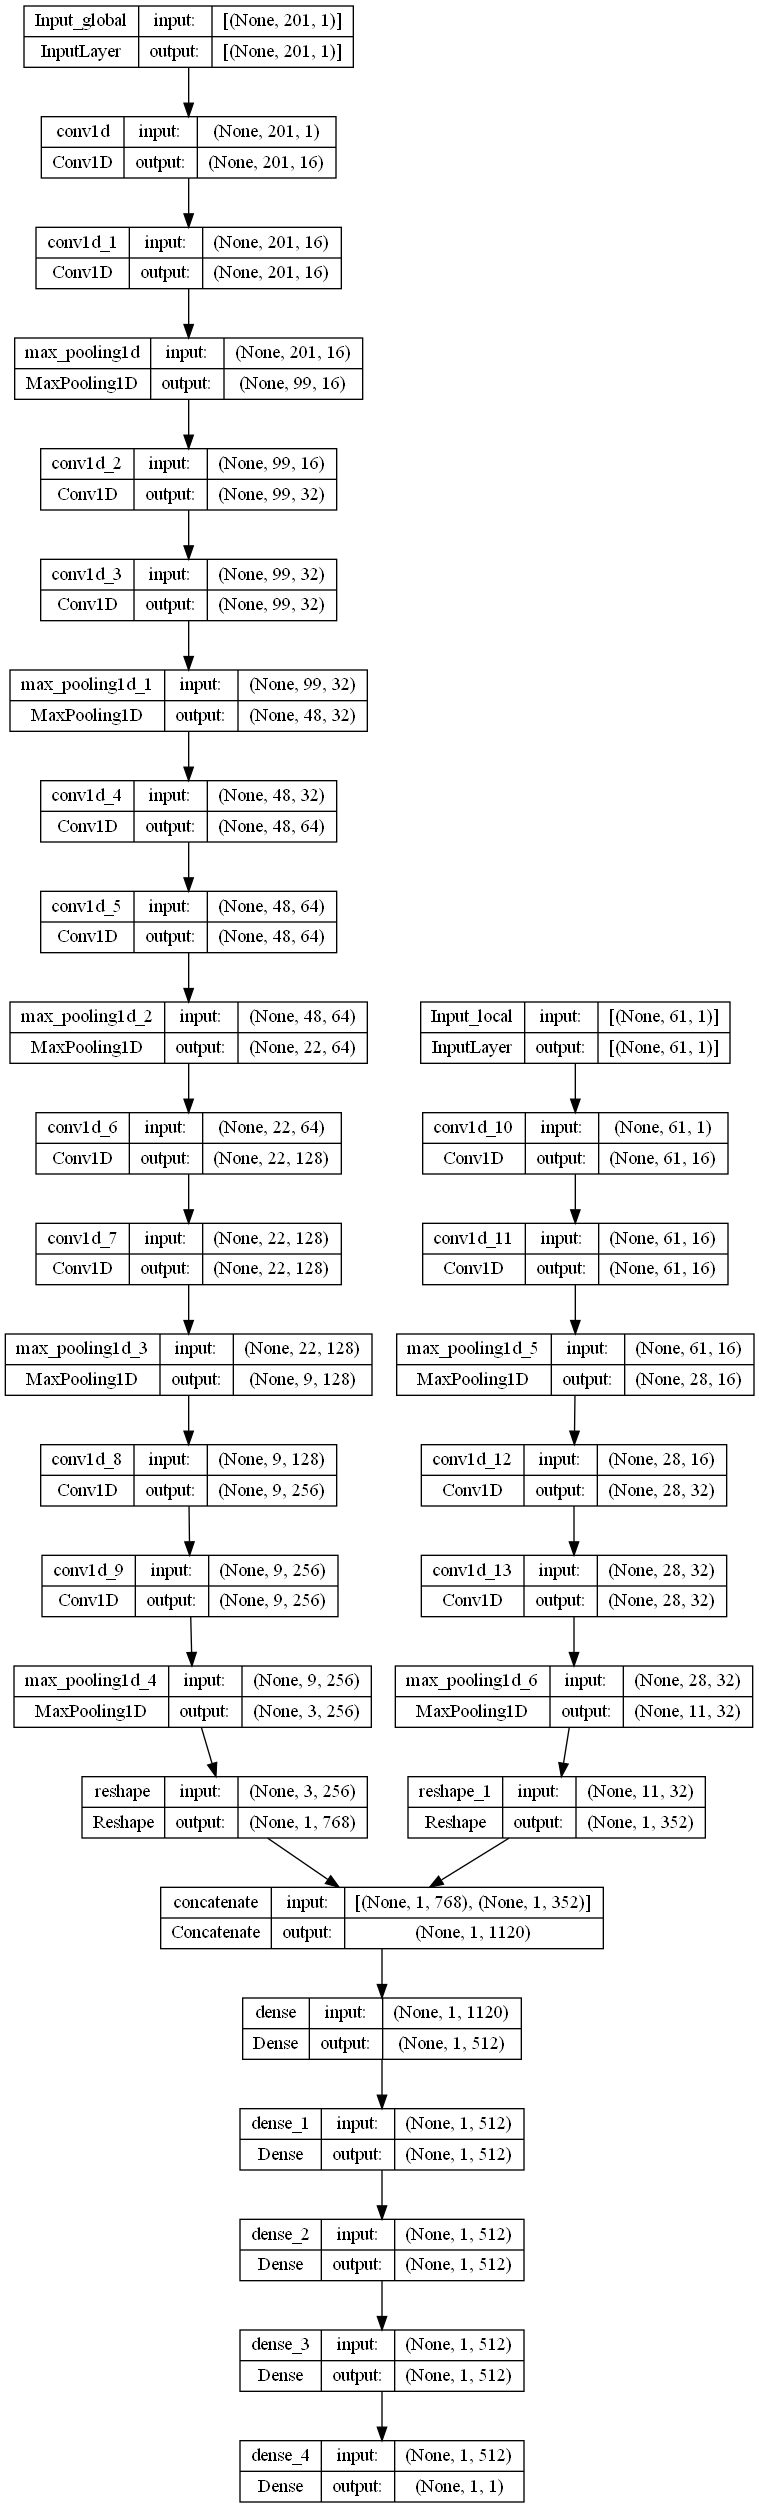

In [20]:
model_astronet = astronetTriageCNN(name = 'Astronet-Triage', num_pre_logits_hidden_layers = 4,pre_logits_hidden_layer_size= 512, output_dim = 1, 
                        input_shape_g=(201,1), activation_func_g='relu', 
                        cnn_num_blocks_g=5, cnn_initial_num_filters_g=16, cnn_block_filter_factor_g=2, cnn_block_size_g=2, 
                        cnn_kernel_size_g=5, convolution_padding_g='same', pool_size_g=5, pool_strides_g=2,
                        input_shape_l=(61,1), activation_func_l='relu', cnn_num_blocks_l=2, 
                        cnn_initial_num_filters_l=16, cnn_block_filter_factor_l=2, cnn_block_size_l=2, cnn_kernel_size_l=5,
                        convolution_padding_l='same', pool_size_l=7, pool_strides_l=2)

model_astronet.summary()

keras.utils.plot_model(model_astronet, show_shapes=True)

## Yeh (2020)

Se mofidica el tamaño de entrada del modelo CNNModelP45A para calzar con el input de 201 features (global)

In [20]:
fjson='CNNModelP45A_global.json'
json_file = open(fjson, 'r')
loaded_model_json = json_file.read()
json_file.close()
CNNModelP45A_global = keras.models.model_from_json(loaded_model_json)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 197, 64)           384       
                                                                 
 conv1d_2 (Conv1D)           (None, 193, 64)           20544     
                                                                 
 conv1d_3 (Conv1D)           (None, 189, 64)           20544     
                                                                 
 conv1d_4 (Conv1D)           (None, 185, 64)           20544     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

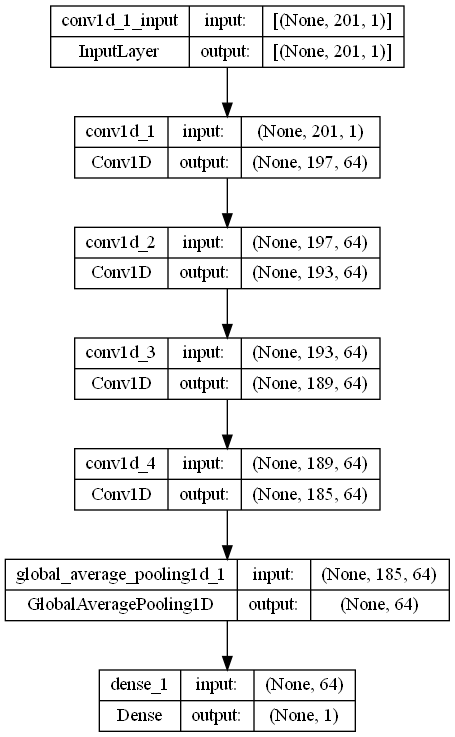

In [21]:

CNNModelP45A_global.summary()

keras.utils.plot_model(CNNModelP45A_global, show_shapes=True)

### Cross Validation

In [22]:
from sklearn.model_selection import KFold


In [23]:
def CrossValidation_visualization(model_name = "astronet", n_splits = 10, only_global = False):
    
    list_precision_PC = []
    list_precision_NOT_PC = [] 
    list_recall_PC = [] 
    list_recall_NOT_PC = []
    list_roc_auc = [] 
    
    for i in range(n_splits): # load all models
        try:
            model = keras.models.load_model(f'models/{model_name}_fold_{i}.h5')
        except:
            return
        print("---------------------------------------------------")
        print(f'Model name: models/{model_name}_fold_{i}.h5')
        print(model)
        
        
        
        X_val_global = np.load(f'models/{model_name}_fold_{i}_X_val_global.npy')
        y_val = np.load(f'models/{model_name}_fold_{i}_y_val.npy') # astronet_fold_1_y_val
        
        prediction_labels = []
        prediction_scores = []
        
        if (only_global):
        
            prediction = model.predict(X_val_global)
   
            for i in range(X_val_global.shape[0]):
                prediction_scores.append(prediction[i][0])
                if (prediction[i][0] >= 0.5):
                    prediction_labels.append([1.])
                else:
                    prediction_labels.append([0.])
        
        else: # global and local
            X_val_local = np.load(f'models/{model_name}_fold_{i}_X_val_local.npy')

            prediction = model.predict( [X_val_global, X_val_local] )

            for i in range(X_val_global.shape[0]):
                prediction_scores.append(prediction[i][0][0])
                
                if (prediction[i][0][0] >= 0.5):
                    prediction_labels.append([1.])
                else:
                    prediction_labels.append([0.])
        
        
        prediction_labels = np.array(prediction_labels)
        
        auc_roc = roc_auc_score(y_val, prediction_scores)
        print("Model Accuracy (Validation set): ", accuracy_score(y_val, prediction_labels))
        print("AUC-ROC (Validation set):", auc_roc)

        target_names = ["NOT_PC", "PC"]
        print("\nConfusion Matrix\n")
        fig, ax = plt.subplots(figsize=(3, 3))

        cm = confusion_matrix(y_val, prediction_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
        plt.show()


        np.set_printoptions(precision=2)
        print(classification_report(y_val, prediction_labels, target_names = target_names))
        
        report = classification_report(y_val, prediction_labels, target_names = target_names, output_dict = True)
        
        print()
        print()
        
        list_precision_PC.append(report['PC']['precision'])
        list_precision_NOT_PC.append(report['NOT_PC']['precision'])
        list_recall_PC.append(report['PC']['recall']) 
        list_recall_NOT_PC.append(report['NOT_PC']['recall'])
        list_roc_auc.append(auc_roc)
    
    print("------------------------------------")
    print("Mean PC precision: ", np.mean(list_precision_PC))
    print("Mean NOT_PC precision: ", np.mean(list_precision_NOT_PC))
    print("Mean PC recall: ", np.mean(list_recall_PC))
    print("Mean NOT_PC recall: ", np.mean(list_recall_NOT_PC))
    print("Mean auc_roc: ", np.mean(list_roc_auc))
    print("------------------------------------")

        

In [24]:
_batch_size = 64 # Numero de ejemplos por gradient update.

train_size = int(0.9*np.unique(data_train_full_util["index"]).shape[0])

n_mini_batchs = int(np.ceil(train_size / _batch_size)) 

n_epochs = int(np.ceil(14000/n_mini_batchs))

print("Train size: ", train_size)
print(f"Número de mini-batch por epoch: {n_mini_batchs}")
print("Numero epochs: ", n_epochs)

Train size:  10476
Número de mini-batch por epoch: 164
Numero epochs:  86


In [39]:
def CrossValidation(model_name = "astronet", n_splits = 10, random_state = 85738196):

    #kf = KFold(n_splits = n_splits, shuffle = True, random_state = random_state)
    kf = KFold(n_splits = n_splits)

    folder = "GeneratedSamples"
    
    unique_indexs = np.unique(data_train_full_util["index"]).copy()
    np.random.seed(random_state)
    np.random.shuffle(unique_indexs)

    list_epochs_used = [] # count for the early stopping
    
    for i, (train_idx, validation_idx) in enumerate(kf.split(unique_indexs)):

        print(f"Fold {i}:")
        print(len(train_idx))
        print(len(validation_idx))

        #print(f"  Train: index={train_idx}")
        #print(f"  Validation:  index={validation_idx}")

        train_indexs  = [unique_indexs[idx] for idx in train_idx] 
        validation_indexs = [unique_indexs[idx] for idx in validation_idx]

        data_train = data_train_full_util[data_train_full_util['index'].isin(train_indexs)]
        data_validation = data_train_full_util[data_train_full_util['index'].isin(validation_indexs)]

        print("data_train.shape[0]//2: ", data_train.shape[0]//2)
        print("data_validation.shape[0]//2: ", data_validation.shape[0]//2)

        XY = [] # train set
        for idx in np.unique(data_train["index"]):
            data_local, data_global, info = get_example(idx, folder, data_train, only_info = False)

            if (info['label'] == 'PC'):
                label = 1
            else:
                label = 0
            XY.append([idx, data_global[1, :], data_local[1, :],  label])


        XY_val = [] # validation set
        for idx in np.unique(data_validation["index"]):
            data_local, data_global, info = get_example(idx, folder, data_validation, only_info = False)
            if (info['label'] == 'PC'):
                label = 1
            else:
                label = 0
            XY_val.append([idx, data_global[1, :], data_local[1, :], label])


        XY = np.array(XY, dtype=object)
        XY_val = np.array(XY_val, dtype=object)

        #np.random.seed((i+1)*957362)
        #np.random.shuffle(XY)
        #np.random.shuffle(XY_val)
        
        

        print(XY.shape)
        print(XY_val.shape)


        X_train_global = np.stack(XY[:,1])
        X_train_local = np.stack(XY[:,2])
        y_train = XY[:,3].reshape((-1,1)).astype('float32')


        X_val_global = np.stack(XY_val[:,1])
        X_val_local = np.stack(XY_val[:,2])
        y_val = XY_val[:,3].reshape((-1,1)).astype('float32')



        print("X_train_global.shape: ", X_train_global.shape)
        print("y_train.shape: ",y_train.shape)
        print("X_val_global.shape: ",X_val_global.shape)

        print("X_train_local.shape: ",X_train_local.shape)
        print("X_val_local.shape: ",X_val_local.shape)

        print("y_val.shape: ", y_val.shape)

        batch_size = _batch_size 
        learning_rate = 1e-05
        st = time.time()
        if (model_name == "astronet"):
            n_epochs = 292
            #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights = True)
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights = False)
            model = astronetTriageCNN(name = 'Astronet-Triage', num_pre_logits_hidden_layers = 4,pre_logits_hidden_layer_size= 512, output_dim = 1, 
                                input_shape_g=(201,1), activation_func_g='relu', 
                                cnn_num_blocks_g=5, cnn_initial_num_filters_g=16, cnn_block_filter_factor_g=2, cnn_block_size_g=2, 
                                cnn_kernel_size_g=5, convolution_padding_g='same', pool_size_g=5, pool_strides_g=2,
                                input_shape_l=(61,1), activation_func_l='relu', cnn_num_blocks_l=2, 
                                cnn_initial_num_filters_l=16, cnn_block_filter_factor_l=2, cnn_block_size_l=2, cnn_kernel_size_l=5,
                                convolution_padding_l='same', pool_size_l=7, pool_strides_l=2)
            
            model.compile( loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(),
                            keras.metrics.BinaryAccuracy()], optimizer=tf.optimizers.Adam(learning_rate))

            print("n_epochs: ", n_epochs)
            history = model.fit(
                x = [X_train_global, X_train_local],
                y = y_train,
                batch_size=_batch_size,
                epochs=n_epochs,
                verbose=1,
                validation_data=([X_val_global, X_val_local], y_val),
                callbacks=[callback]
            )
        elif (model_name == "astronet_final"):
            n_epochs = 60
            model = astronetTriageCNN(name = 'Astronet-Triage', num_pre_logits_hidden_layers = 4,pre_logits_hidden_layer_size= 512, output_dim = 1, 
                                input_shape_g=(201,1), activation_func_g='relu', 
                                cnn_num_blocks_g=5, cnn_initial_num_filters_g=16, cnn_block_filter_factor_g=2, cnn_block_size_g=2, 
                                cnn_kernel_size_g=5, convolution_padding_g='same', pool_size_g=5, pool_strides_g=2,
                                input_shape_l=(61,1), activation_func_l='relu', cnn_num_blocks_l=2, 
                                cnn_initial_num_filters_l=16, cnn_block_filter_factor_l=2, cnn_block_size_l=2, cnn_kernel_size_l=5,
                                convolution_padding_l='same', pool_size_l=7, pool_strides_l=2)
            
            st = time.time()
            model.compile( loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(),
                            keras.metrics.BinaryAccuracy()], optimizer=tf.optimizers.Adam(learning_rate))

            print("n_epochs: ", n_epochs)
            history = model.fit(
                x = [X_train_global, X_train_local],
                y = y_train,
                batch_size=_batch_size,
                epochs=n_epochs,
                verbose=1,
                validation_data=([X_val_global, X_val_local], y_val),
            )
        elif (model_name == "CNNModelP45A_global"):
            
            fjson='CNNModelP45A_global.json'
            json_file = open(fjson, 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            model = keras.models.model_from_json(loaded_model_json)
            
            n_epochs = 292
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights = False)
            model.compile( loss='binary_crossentropy', metrics=[keras.metrics.Precision(), 
                                                keras.metrics.Recall(), keras.metrics.BinaryAccuracy()], 
                                                optimizer=tf.optimizers.Adam(learning_rate))

            history = model.fit(
                x = X_train_global,
                y = y_train,
                batch_size=_batch_size,
                epochs=n_epochs,
                verbose=1,
                validation_data=(X_val_global, y_val),
                callbacks=[callback]
            )
        
        else:
            return

        
        
        list_epochs_used.append(len(history.history['binary_accuracy']))
       
        
        et = time.time()
        print(f'Fold {i}. Execution time: {et - st} seconds')
        '''
        fig = plt.figure(figsize=(4, 3))    
        plt.plot(history.history['binary_accuracy'])
        plt.plot(history.history['val_binary_accuracy'])
        plt.title(f'Loss. Model: {model_name}')
        plt.ylabel('binary_accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        '''
        fig = plt.figure(figsize=(4, 3))    
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'Loss. Model: {model_name}')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
                
        
        model.save(f'models/{model_name}_fold_{i}.h5')        
        np.save(f'models/{model_name}_fold_{i}_X_val_global.npy', X_val_global)
        np.save(f'models/{model_name}_fold_{i}_X_val_local.npy', X_val_local)
        np.save(f'models/{model_name}_fold_{i}_y_val.npy', y_val)
    
    print("list n_epochs used: ", list_epochs_used)
    print("mean: ", np.mean(list_epochs_used))
        

Fold 0:
10476
1165
data_train.shape[0]//2:  10476
data_validation.shape[0]//2:  1165
(10476, 4)
(1165, 4)
X_train_global.shape:  (10476, 201)
y_train.shape:  (10476, 1)
X_val_global.shape:  (1165, 201)
X_train_local.shape:  (10476, 61)
X_val_local.shape:  (1165, 61)
y_val.shape:  (1165, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  292
Epoch 1/292
164/164 [==============================] - 9s 46ms/step - loss: 0.5215 - precision_4: 0.1591 - recall_4: 0.0126 - binary_accuracy: 0.8325 - val_loss: 0.3143 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - val_binary_accuracy: 0.8515
Epoch 2/292
164/164 [==============================] - 7s 42ms/step - loss: 0.2651 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - binary_accuracy: 0.8411 - val_loss: 0.1849 - val_precision_4: 1.0000 - val_recall_4: 0.0058 - val_binary_accuracy: 0.8524
Epoch 3/292
164/164 [=================

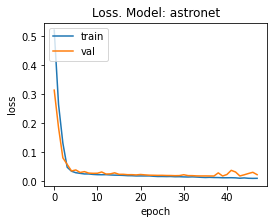

Fold 1:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  292
Epoch 1/292
164/164 [==============================] - 9s 47ms/step - loss: 0.5255 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - binary_accuracy: 0.8378 - val_loss: 0.2786 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_binary_accuracy: 0.8557
Epoch 2/292
164/164 [==============================] - 7s 45ms/step - loss: 0.1872 - precision_5: 0.9940 - recall_5: 0.3982 - binary_accuracy: 0.9037 - val_loss: 0.0915 - val_precision_5: 0.9862 - val_recall_5: 0.8512 - val_binary_accuracy: 0.9768
Epoch 3/292
164/164 [=================

Epoch 65/292
164/164 [==============================] - 7s 44ms/step - loss: 0.0100 - precision_5: 0.9946 - recall_5: 0.9886 - binary_accuracy: 0.9973 - val_loss: 0.0150 - val_precision_5: 0.9939 - val_recall_5: 0.9762 - val_binary_accuracy: 0.9957
Epoch 66/292
164/164 [==============================] - 7s 44ms/step - loss: 0.0101 - precision_5: 0.9952 - recall_5: 0.9862 - binary_accuracy: 0.9970 - val_loss: 0.0184 - val_precision_5: 0.9708 - val_recall_5: 0.9881 - val_binary_accuracy: 0.9940
Epoch 67/292
164/164 [==============================] - 7s 44ms/step - loss: 0.0093 - precision_5: 0.9946 - recall_5: 0.9910 - binary_accuracy: 0.9977 - val_loss: 0.0165 - val_precision_5: 1.0000 - val_recall_5: 0.9702 - val_binary_accuracy: 0.9957
Epoch 68/292
164/164 [==============================] - 7s 46ms/step - loss: 0.0102 - precision_5: 0.9934 - recall_5: 0.9886 - binary_accuracy: 0.9971 - val_loss: 0.0176 - val_precision_5: 0.9708 - val_recall_5: 0.9881 - val_binary_accuracy: 0.9940
Epoc

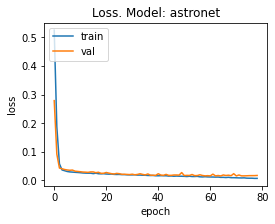

Fold 2:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  292
Epoch 1/292
164/164 [==============================] - 10s 51ms/step - loss: 0.5117 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - binary_accuracy: 0.8392 - val_loss: 0.2560 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_binary_accuracy: 0.8531
Epoch 2/292
164/164 [==============================] - 7s 45ms/step - loss: 0.1586 - precision_6: 0.9921 - recall_6: 0.5291 - binary_accuracy: 0.9244 - val_loss: 0.0803 - val_precision_6: 0.9684 - val_recall_6: 0.8947 - val_binary_accuracy: 0.9802
Epoch 3/292
164/164 [================

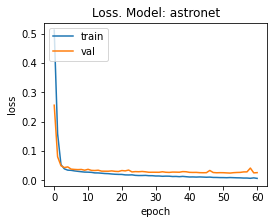

Fold 3:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  292
Epoch 1/292
164/164 [==============================] - 10s 52ms/step - loss: 0.5255 - precision_7: 0.1538 - recall_7: 0.0340 - binary_accuracy: 0.8188 - val_loss: 0.3269 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_binary_accuracy: 0.8351
Epoch 2/292
164/164 [==============================] - 8s 48ms/step - loss: 0.1990 - precision_7: 0.9897 - recall_7: 0.3493 - binary_accuracy: 0.8972 - val_loss: 0.0705 - val_precision_7: 0.9944 - val_recall_7: 0.9167 - val_binary_accuracy: 0.9854
Epoch 3/292
164/164 [========================

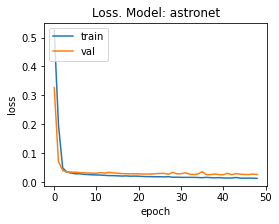

Fold 4:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  292
Epoch 1/292
164/164 [==============================] - 8s 42ms/step - loss: 0.5307 - precision_8: 0.1338 - recall_8: 0.0255 - binary_accuracy: 0.8206 - val_loss: 0.3334 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_binary_accuracy: 0.8385
Epoch 2/292
164/164 [==============================] - 6s 39ms/step - loss: 0.2123 - precision_8: 0.9978 - recall_8: 0.2733 - binary_accuracy: 0.8855 - val_loss: 0.1096 - val_precision_8: 1.0000 - val_recall_8: 0.8191 - val_binary_accuracy: 0.9708
Epoch 3/292
164/164 [=========================

Epoch 65/292
164/164 [==============================] - 7s 41ms/step - loss: 0.0087 - precision_8: 0.9939 - recall_8: 0.9909 - binary_accuracy: 0.9976 - val_loss: 0.0242 - val_precision_8: 0.9838 - val_recall_8: 0.9681 - val_binary_accuracy: 0.9923
Epoch 66/292
164/164 [==============================] - 7s 42ms/step - loss: 0.0088 - precision_8: 0.9951 - recall_8: 0.9885 - binary_accuracy: 0.9974 - val_loss: 0.0297 - val_precision_8: 1.0000 - val_recall_8: 0.9681 - val_binary_accuracy: 0.9948
Fold 4. Execution time: 430.4291260242462 seconds


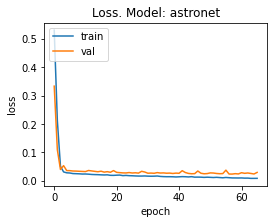

Fold 5:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  292
Epoch 1/292
164/164 [==============================] - 9s 43ms/step - loss: 0.5120 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00 - binary_accuracy: 0.8425 - val_loss: 0.3330 - val_precision_9: 0.0000e+00 - val_recall_9: 0.0000e+00 - val_binary_accuracy: 0.8385
Epoch 2/292
164/164 [==============================] - 7s 40ms/step - loss: 0.2121 - precision_9: 0.9961 - recall_9: 0.3061 - binary_accuracy: 0.8905 - val_loss: 0.0837 - val_precision_9: 1.0000 - val_recall_9: 0.9043 - val_binary_accuracy: 0.9845
Epoch 3/292
164/164 [=================

Epoch 65/292
164/164 [==============================] - 7s 44ms/step - loss: 0.0075 - precision_9: 0.9951 - recall_9: 0.9909 - binary_accuracy: 0.9978 - val_loss: 0.0095 - val_precision_9: 0.9893 - val_recall_9: 0.9840 - val_binary_accuracy: 0.9957
Epoch 66/292
164/164 [==============================] - 8s 46ms/step - loss: 0.0075 - precision_9: 0.9969 - recall_9: 0.9891 - binary_accuracy: 0.9978 - val_loss: 0.0111 - val_precision_9: 1.0000 - val_recall_9: 0.9734 - val_binary_accuracy: 0.9957
Epoch 67/292
164/164 [==============================] - 7s 43ms/step - loss: 0.0068 - precision_9: 0.9963 - recall_9: 0.9921 - binary_accuracy: 0.9982 - val_loss: 0.0111 - val_precision_9: 0.9841 - val_recall_9: 0.9894 - val_binary_accuracy: 0.9957
Epoch 68/292
164/164 [==============================] - 7s 42ms/step - loss: 0.0076 - precision_9: 0.9945 - recall_9: 0.9927 - binary_accuracy: 0.9980 - val_loss: 0.0114 - val_precision_9: 1.0000 - val_recall_9: 0.9681 - val_binary_accuracy: 0.9948
Epoc

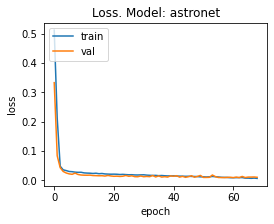

Fold 6:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  292
Epoch 1/292
164/164 [==============================] - 9s 45ms/step - loss: 0.4865 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - binary_accuracy: 0.8413 - val_loss: 0.2846 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_binary_accuracy: 0.8497
Epoch 2/292
164/164 [==============================] - 7s 42ms/step - loss: 0.2422 - precision_10: 1.0000 - recall_10: 0.0066 - binary_accuracy: 0.8423 - val_loss: 0.1677 - val_precision_10: 1.0000 - val_recall_10: 0.3657 - val_binary_accuracy: 0.9046
Epoch 3/292
164/164 [=========

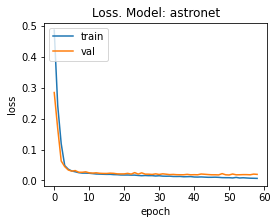

Fold 7:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  292
Epoch 1/292
164/164 [==============================] - 9s 46ms/step - loss: 0.5155 - precision_11: 0.1302 - recall_11: 0.0172 - binary_accuracy: 0.8293 - val_loss: 0.3231 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_binary_accuracy: 0.8204
Epoch 2/292
164/164 [==============================] - 7s 43ms/step - loss: 0.2198 - precision_11: 0.9961 - recall_11: 0.1565 - binary_accuracy: 0.8688 - val_loss: 0.1645 - val_precision_11: 1.0000 - val_recall_11: 0.6890 - val_binary_accuracy: 0.9442
Epoch 3/292
164/164 [=================

Epoch 32/292
164/164 [==============================] - 7s 40ms/step - loss: 0.0146 - precision_11: 0.9907 - recall_11: 0.9840 - binary_accuracy: 0.9961 - val_loss: 0.0106 - val_precision_11: 0.9951 - val_recall_11: 0.9809 - val_binary_accuracy: 0.9957
Epoch 33/292
164/164 [==============================] - 6s 39ms/step - loss: 0.0133 - precision_11: 0.9920 - recall_11: 0.9834 - binary_accuracy: 0.9962 - val_loss: 0.0106 - val_precision_11: 0.9951 - val_recall_11: 0.9809 - val_binary_accuracy: 0.9957
Epoch 34/292
164/164 [==============================] - 7s 42ms/step - loss: 0.0142 - precision_11: 0.9901 - recall_11: 0.9840 - binary_accuracy: 0.9960 - val_loss: 0.0107 - val_precision_11: 0.9857 - val_recall_11: 0.9904 - val_binary_accuracy: 0.9957
Epoch 35/292
164/164 [==============================] - 7s 46ms/step - loss: 0.0131 - precision_11: 0.9895 - recall_11: 0.9847 - binary_accuracy: 0.9960 - val_loss: 0.0105 - val_precision_11: 0.9904 - val_recall_11: 0.9856 - val_binary_accur

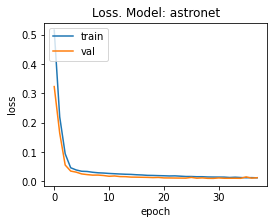

Fold 8:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  292
Epoch 1/292
164/164 [==============================] - 10s 54ms/step - loss: 0.5061 - precision_12: 0.0119 - recall_12: 6.0680e-04 - binary_accuracy: 0.8349 - val_loss: 0.3402 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00 - val_binary_accuracy: 0.8368
Epoch 2/292
164/164 [==============================] - 7s 45ms/step - loss: 0.1766 - precision_12: 0.9867 - recall_12: 0.4502 - binary_accuracy: 0.9126 - val_loss: 0.0514 - val_precision_12: 0.9730 - val_recall_12: 0.9474 - val_binary_accuracy: 0.9871
Epoch 3/292
164/164 [============

Epoch 32/292
164/164 [==============================] - 8s 47ms/step - loss: 0.0180 - precision_12: 0.9896 - recall_12: 0.9782 - binary_accuracy: 0.9949 - val_loss: 0.0224 - val_precision_12: 0.9788 - val_recall_12: 0.9737 - val_binary_accuracy: 0.9923
Epoch 33/292
164/164 [==============================] - 8s 46ms/step - loss: 0.0182 - precision_12: 0.9872 - recall_12: 0.9794 - binary_accuracy: 0.9948 - val_loss: 0.0229 - val_precision_12: 0.9688 - val_recall_12: 0.9789 - val_binary_accuracy: 0.9914
Epoch 34/292
164/164 [==============================] - 8s 46ms/step - loss: 0.0174 - precision_12: 0.9884 - recall_12: 0.9788 - binary_accuracy: 0.9948 - val_loss: 0.0223 - val_precision_12: 0.9688 - val_recall_12: 0.9789 - val_binary_accuracy: 0.9914
Epoch 35/292
164/164 [==============================] - 8s 46ms/step - loss: 0.0173 - precision_12: 0.9908 - recall_12: 0.9806 - binary_accuracy: 0.9955 - val_loss: 0.0216 - val_precision_12: 0.9788 - val_recall_12: 0.9737 - val_binary_accur

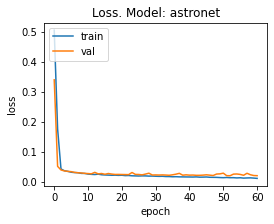

Fold 9:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  292
Epoch 1/292
164/164 [==============================] - 8s 39ms/step - loss: 0.4814 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - binary_accuracy: 0.8421 - val_loss: 0.3012 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_binary_accuracy: 0.8419
Epoch 2/292
164/164 [==============================] - 6s 37ms/step - loss: 0.2185 - precision_13: 1.0000 - recall_13: 0.1989 - binary_accuracy: 0.8735 - val_loss: 0.1226 - val_precision_13: 1.0000 - val_recall_13: 0.8478 - val_binary_accuracy: 0.9759
Epoch 3/292
164/164 [=========

164/164 [==============================] - 6s 37ms/step - loss: 0.0084 - precision_13: 0.9970 - recall_13: 0.9891 - binary_accuracy: 0.9978 - val_loss: 0.0171 - val_precision_13: 0.9891 - val_recall_13: 0.9891 - val_binary_accuracy: 0.9966
Epoch 64/292
164/164 [==============================] - 6s 38ms/step - loss: 0.0088 - precision_13: 0.9939 - recall_13: 0.9879 - binary_accuracy: 0.9971 - val_loss: 0.0168 - val_precision_13: 0.9945 - val_recall_13: 0.9837 - val_binary_accuracy: 0.9966
Epoch 65/292
164/164 [==============================] - 6s 39ms/step - loss: 0.0076 - precision_13: 0.9957 - recall_13: 0.9909 - binary_accuracy: 0.9979 - val_loss: 0.0167 - val_precision_13: 0.9945 - val_recall_13: 0.9837 - val_binary_accuracy: 0.9966
Epoch 66/292
164/164 [==============================] - 6s 39ms/step - loss: 0.0076 - precision_13: 0.9951 - recall_13: 0.9915 - binary_accuracy: 0.9979 - val_loss: 0.0179 - val_precision_13: 0.9945 - val_recall_13: 0.9837 - val_binary_accuracy: 0.9966
E

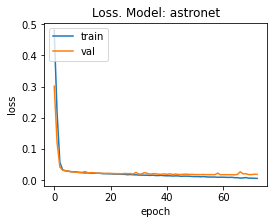

list n_epochs used:  [48, 79, 61, 49, 66, 69, 59, 38, 61, 73]
mean:  60.3


In [28]:
# CV astronet 10 folds

CrossValidation("astronet", n_splits = 10, random_state = 95061385)

Fold 0:
10476
1165
data_train.shape[0]//2:  10476
data_validation.shape[0]//2:  1165
(10476, 4)
(1165, 4)
X_train_global.shape:  (10476, 201)
y_train.shape:  (10476, 1)
X_val_global.shape:  (1165, 201)
X_train_local.shape:  (10476, 61)
X_val_local.shape:  (1165, 61)
y_val.shape:  (1165, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  60
Epoch 1/60
164/164 [==============================] - 11s 57ms/step - loss: 0.4919 - precision_35: 0.0000e+00 - recall_35: 0.0000e+00 - binary_accuracy: 0.8409 - val_loss: 0.2836 - val_precision_35: 0.0000e+00 - val_recall_35: 0.0000e+00 - val_binary_accuracy: 0.8515
Epoch 2/60
164/164 [==============================] - 9s 58ms/step - loss: 0.1827 - precision_35: 0.9939 - recall_35: 0.3922 - binary_accuracy: 0.9030 - val_loss: 0.0704 - val_precision_35: 0.9697 - val_recall_35: 0.9249 - val_binary_accuracy: 0.9845
Epoch 3/60
164/164 [============

Epoch 32/60
164/164 [==============================] - 9s 57ms/step - loss: 0.0161 - precision_35: 0.9861 - recall_35: 0.9808 - binary_accuracy: 0.9947 - val_loss: 0.0187 - val_precision_35: 0.9824 - val_recall_35: 0.9653 - val_binary_accuracy: 0.9923
Epoch 33/60
164/164 [==============================] - 9s 56ms/step - loss: 0.0163 - precision_35: 0.9885 - recall_35: 0.9802 - binary_accuracy: 0.9950 - val_loss: 0.0182 - val_precision_35: 0.9827 - val_recall_35: 0.9827 - val_binary_accuracy: 0.9948
Epoch 34/60
164/164 [==============================] - 9s 57ms/step - loss: 0.0154 - precision_35: 0.9879 - recall_35: 0.9826 - binary_accuracy: 0.9953 - val_loss: 0.0187 - val_precision_35: 0.9882 - val_recall_35: 0.9711 - val_binary_accuracy: 0.9940
Epoch 35/60
164/164 [==============================] - 9s 56ms/step - loss: 0.0149 - precision_35: 0.9909 - recall_35: 0.9838 - binary_accuracy: 0.9960 - val_loss: 0.0181 - val_precision_35: 0.9827 - val_recall_35: 0.9827 - val_binary_accuracy:

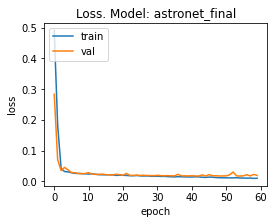

Fold 1:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  60
Epoch 1/60
164/164 [==============================] - 10s 52ms/step - loss: 0.5318 - precision_36: 0.2179 - recall_36: 0.0407 - binary_accuracy: 0.8238 - val_loss: 0.3204 - val_precision_36: 0.0000e+00 - val_recall_36: 0.0000e+00 - val_binary_accuracy: 0.8557
Epoch 2/60
164/164 [==============================] - 8s 47ms/step - loss: 0.2094 - precision_36: 0.9877 - recall_36: 0.3365 - binary_accuracy: 0.8936 - val_loss: 0.0749 - val_precision_36: 0.9868 - val_recall_36: 0.8929 - val_binary_accuracy: 0.9828
Epoch 3/60
164/164 [====================

Epoch 32/60
164/164 [==============================] - 8s 50ms/step - loss: 0.0180 - precision_36: 0.9885 - recall_36: 0.9808 - binary_accuracy: 0.9951 - val_loss: 0.0188 - val_precision_36: 0.9651 - val_recall_36: 0.9881 - val_binary_accuracy: 0.9931
Epoch 33/60
164/164 [==============================] - 8s 47ms/step - loss: 0.0182 - precision_36: 0.9885 - recall_36: 0.9778 - binary_accuracy: 0.9947 - val_loss: 0.0172 - val_precision_36: 1.0000 - val_recall_36: 0.9821 - val_binary_accuracy: 0.9974
Epoch 34/60
164/164 [==============================] - 8s 50ms/step - loss: 0.0175 - precision_36: 0.9873 - recall_36: 0.9808 - binary_accuracy: 0.9949 - val_loss: 0.0166 - val_precision_36: 1.0000 - val_recall_36: 0.9821 - val_binary_accuracy: 0.9974
Epoch 35/60
164/164 [==============================] - 8s 49ms/step - loss: 0.0181 - precision_36: 0.9873 - recall_36: 0.9796 - binary_accuracy: 0.9948 - val_loss: 0.0167 - val_precision_36: 0.9940 - val_recall_36: 0.9821 - val_binary_accuracy:

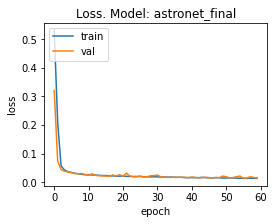

Fold 2:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  60
Epoch 1/60
164/164 [==============================] - 9s 45ms/step - loss: 0.5010 - precision_37: 0.2222 - recall_37: 0.0024 - binary_accuracy: 0.8399 - val_loss: 0.2804 - val_precision_37: 0.0000e+00 - val_recall_37: 0.0000e+00 - val_binary_accuracy: 0.8531
Epoch 2/60
164/164 [==============================] - 7s 41ms/step - loss: 0.1234 - precision_37: 0.9858 - recall_37: 0.6641 - binary_accuracy: 0.9450 - val_loss: 0.0398 - val_precision_37: 0.9701 - val_recall_37: 0.9474 - val_binary_accuracy: 0.9880
Epoch 3/60
164/164 [=====================

Epoch 32/60
164/164 [==============================] - 7s 44ms/step - loss: 0.0182 - precision_37: 0.9903 - recall_37: 0.9826 - binary_accuracy: 0.9957 - val_loss: 0.0269 - val_precision_37: 0.9649 - val_recall_37: 0.9649 - val_binary_accuracy: 0.9897
Epoch 33/60
164/164 [==============================] - 7s 45ms/step - loss: 0.0179 - precision_37: 0.9873 - recall_37: 0.9802 - binary_accuracy: 0.9948 - val_loss: 0.0302 - val_precision_37: 0.9878 - val_recall_37: 0.9474 - val_binary_accuracy: 0.9905
Epoch 34/60
164/164 [==============================] - 7s 44ms/step - loss: 0.0173 - precision_37: 0.9873 - recall_37: 0.9814 - binary_accuracy: 0.9950 - val_loss: 0.0281 - val_precision_37: 0.9538 - val_recall_37: 0.9649 - val_binary_accuracy: 0.9880
Epoch 35/60
164/164 [==============================] - 7s 46ms/step - loss: 0.0177 - precision_37: 0.9885 - recall_37: 0.9808 - binary_accuracy: 0.9951 - val_loss: 0.0285 - val_precision_37: 0.9538 - val_recall_37: 0.9649 - val_binary_accuracy:

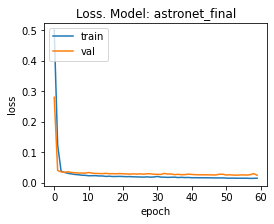

Fold 3:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  60
Epoch 1/60
164/164 [==============================] - 10s 52ms/step - loss: 0.4922 - precision_38: 0.0000e+00 - recall_38: 0.0000e+00 - binary_accuracy: 0.8428 - val_loss: 0.2880 - val_precision_38: 0.0000e+00 - val_recall_38: 0.0000e+00 - val_binary_accuracy: 0.8351
Epoch 2/60
164/164 [==============================] - 8s 46ms/step - loss: 0.2353 - precision_38: 0.9889 - recall_38: 0.0541 - binary_accuracy: 0.8513 - val_loss: 0.1803 - val_precision_38: 1.0000 - val_recall_38: 0.4375 - val_binary_accuracy: 0.9072
Epoch 3/60
164/164 [============

Epoch 32/60
164/164 [==============================] - 8s 52ms/step - loss: 0.0144 - precision_38: 0.9884 - recall_38: 0.9824 - binary_accuracy: 0.9954 - val_loss: 0.0253 - val_precision_38: 0.9946 - val_recall_38: 0.9583 - val_binary_accuracy: 0.9923
Epoch 33/60
164/164 [==============================] - 9s 53ms/step - loss: 0.0141 - precision_38: 0.9884 - recall_38: 0.9830 - binary_accuracy: 0.9955 - val_loss: 0.0233 - val_precision_38: 0.9793 - val_recall_38: 0.9844 - val_binary_accuracy: 0.9940
Epoch 34/60
164/164 [==============================] - 9s 54ms/step - loss: 0.0145 - precision_38: 0.9914 - recall_38: 0.9806 - binary_accuracy: 0.9956 - val_loss: 0.0260 - val_precision_38: 0.9946 - val_recall_38: 0.9635 - val_binary_accuracy: 0.9931
Epoch 35/60
164/164 [==============================] - 8s 52ms/step - loss: 0.0128 - precision_38: 0.9890 - recall_38: 0.9860 - binary_accuracy: 0.9961 - val_loss: 0.0236 - val_precision_38: 0.9947 - val_recall_38: 0.9688 - val_binary_accuracy:

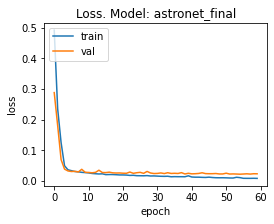

Fold 4:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  60
Epoch 1/60
164/164 [==============================] - 9s 48ms/step - loss: 0.5222 - precision_39: 0.0000e+00 - recall_39: 0.0000e+00 - binary_accuracy: 0.8425 - val_loss: 0.3182 - val_precision_39: 0.0000e+00 - val_recall_39: 0.0000e+00 - val_binary_accuracy: 0.8385
Epoch 2/60
164/164 [==============================] - 8s 48ms/step - loss: 0.2268 - precision_39: 1.0000 - recall_39: 0.1800 - binary_accuracy: 0.8709 - val_loss: 0.1513 - val_precision_39: 1.0000 - val_recall_39: 0.6809 - val_binary_accuracy: 0.9485
Epoch 3/60
164/164 [=============

Epoch 32/60
164/164 [==============================] - 8s 48ms/step - loss: 0.0169 - precision_39: 0.9878 - recall_39: 0.9788 - binary_accuracy: 0.9948 - val_loss: 0.0286 - val_precision_39: 1.0000 - val_recall_39: 0.9681 - val_binary_accuracy: 0.9948
Epoch 33/60
164/164 [==============================] - 8s 48ms/step - loss: 0.0164 - precision_39: 0.9884 - recall_39: 0.9818 - binary_accuracy: 0.9953 - val_loss: 0.0239 - val_precision_39: 0.9945 - val_recall_39: 0.9681 - val_binary_accuracy: 0.9940
Epoch 34/60
164/164 [==============================] - 8s 47ms/step - loss: 0.0150 - precision_39: 0.9866 - recall_39: 0.9836 - binary_accuracy: 0.9953 - val_loss: 0.0233 - val_precision_39: 0.9945 - val_recall_39: 0.9681 - val_binary_accuracy: 0.9940
Epoch 35/60
164/164 [==============================] - 8s 48ms/step - loss: 0.0152 - precision_39: 0.9878 - recall_39: 0.9836 - binary_accuracy: 0.9955 - val_loss: 0.0223 - val_precision_39: 0.9891 - val_recall_39: 0.9681 - val_binary_accuracy:

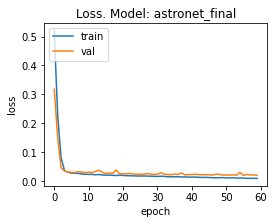

Fold 5:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  60
Epoch 1/60
164/164 [==============================] - 11s 57ms/step - loss: 0.5148 - precision_40: 0.0000e+00 - recall_40: 0.0000e+00 - binary_accuracy: 0.8425 - val_loss: 0.3008 - val_precision_40: 0.0000e+00 - val_recall_40: 0.0000e+00 - val_binary_accuracy: 0.8385
Epoch 2/60
164/164 [==============================] - 9s 57ms/step - loss: 0.1894 - precision_40: 0.9936 - recall_40: 0.3782 - binary_accuracy: 0.9017 - val_loss: 0.1014 - val_precision_40: 0.9777 - val_recall_40: 0.9309 - val_binary_accuracy: 0.9854
Epoch 3/60
164/164 [============

Epoch 32/60
164/164 [==============================] - 9s 53ms/step - loss: 0.0163 - precision_40: 0.9884 - recall_40: 0.9824 - binary_accuracy: 0.9954 - val_loss: 0.0129 - val_precision_40: 0.9840 - val_recall_40: 0.9840 - val_binary_accuracy: 0.9948
Epoch 33/60
164/164 [==============================] - 8s 52ms/step - loss: 0.0168 - precision_40: 0.9872 - recall_40: 0.9824 - binary_accuracy: 0.9952 - val_loss: 0.0125 - val_precision_40: 0.9892 - val_recall_40: 0.9787 - val_binary_accuracy: 0.9948
Epoch 34/60
164/164 [==============================] - 8s 52ms/step - loss: 0.0161 - precision_40: 0.9872 - recall_40: 0.9818 - binary_accuracy: 0.9951 - val_loss: 0.0130 - val_precision_40: 0.9892 - val_recall_40: 0.9787 - val_binary_accuracy: 0.9948
Epoch 35/60
164/164 [==============================] - 8s 51ms/step - loss: 0.0159 - precision_40: 0.9896 - recall_40: 0.9788 - binary_accuracy: 0.9950 - val_loss: 0.0139 - val_precision_40: 1.0000 - val_recall_40: 0.9734 - val_binary_accuracy:

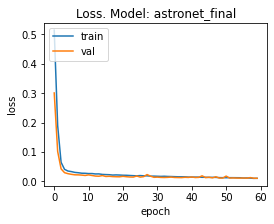

Fold 6:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  60
Epoch 1/60
164/164 [==============================] - 10s 55ms/step - loss: 0.5183 - precision_41: 0.2536 - recall_41: 0.0523 - binary_accuracy: 0.8251 - val_loss: 0.2984 - val_precision_41: 0.0000e+00 - val_recall_41: 0.0000e+00 - val_binary_accuracy: 0.8497
Epoch 2/60
164/164 [==============================] - 8s 48ms/step - loss: 0.1556 - precision_41: 0.9889 - recall_41: 0.5376 - binary_accuracy: 0.9256 - val_loss: 0.0646 - val_precision_41: 0.9202 - val_recall_41: 0.9886 - val_binary_accuracy: 0.9854
Epoch 3/60
164/164 [====================

Epoch 32/60
164/164 [==============================] - 8s 48ms/step - loss: 0.0152 - precision_41: 0.9873 - recall_41: 0.9826 - binary_accuracy: 0.9952 - val_loss: 0.0255 - val_precision_41: 0.9665 - val_recall_41: 0.9886 - val_binary_accuracy: 0.9931
Epoch 33/60
164/164 [==============================] - 8s 48ms/step - loss: 0.0150 - precision_41: 0.9873 - recall_41: 0.9826 - binary_accuracy: 0.9952 - val_loss: 0.0199 - val_precision_41: 0.9942 - val_recall_41: 0.9829 - val_binary_accuracy: 0.9966
Epoch 34/60
164/164 [==============================] - 8s 49ms/step - loss: 0.0148 - precision_41: 0.9873 - recall_41: 0.9844 - binary_accuracy: 0.9955 - val_loss: 0.0198 - val_precision_41: 0.9942 - val_recall_41: 0.9829 - val_binary_accuracy: 0.9966
Epoch 35/60
164/164 [==============================] - 8s 48ms/step - loss: 0.0144 - precision_41: 0.9909 - recall_41: 0.9838 - binary_accuracy: 0.9960 - val_loss: 0.0199 - val_precision_41: 0.9773 - val_recall_41: 0.9829 - val_binary_accuracy:

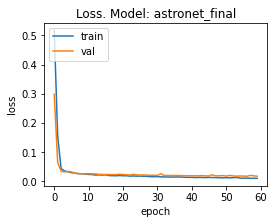

Fold 7:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  60
Epoch 1/60
164/164 [==============================] - 9s 47ms/step - loss: 0.4788 - precision_42: 0.1667 - recall_42: 0.0356 - binary_accuracy: 0.8224 - val_loss: 0.3020 - val_precision_42: 0.0000e+00 - val_recall_42: 0.0000e+00 - val_binary_accuracy: 0.8204
Epoch 2/60
164/164 [==============================] - 7s 45ms/step - loss: 0.2298 - precision_42: 1.0000 - recall_42: 0.0344 - binary_accuracy: 0.8499 - val_loss: 0.1926 - val_precision_42: 1.0000 - val_recall_42: 0.4067 - val_binary_accuracy: 0.8935
Epoch 3/60
164/164 [=====================

Epoch 32/60
164/164 [==============================] - 7s 45ms/step - loss: 0.0143 - precision_42: 0.9901 - recall_42: 0.9797 - binary_accuracy: 0.9953 - val_loss: 0.0098 - val_precision_42: 0.9858 - val_recall_42: 1.0000 - val_binary_accuracy: 0.9974
Epoch 33/60
164/164 [==============================] - 7s 46ms/step - loss: 0.0145 - precision_42: 0.9926 - recall_42: 0.9834 - binary_accuracy: 0.9963 - val_loss: 0.0099 - val_precision_42: 1.0000 - val_recall_42: 0.9713 - val_binary_accuracy: 0.9948
Epoch 34/60
164/164 [==============================] - 8s 47ms/step - loss: 0.0141 - precision_42: 0.9913 - recall_42: 0.9822 - binary_accuracy: 0.9959 - val_loss: 0.0097 - val_precision_42: 1.0000 - val_recall_42: 0.9713 - val_binary_accuracy: 0.9948
Epoch 35/60
164/164 [==============================] - 7s 46ms/step - loss: 0.0138 - precision_42: 0.9926 - recall_42: 0.9822 - binary_accuracy: 0.9961 - val_loss: 0.0086 - val_precision_42: 0.9951 - val_recall_42: 0.9809 - val_binary_accuracy:

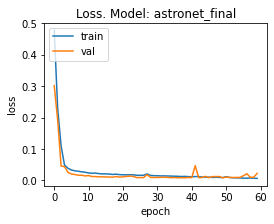

Fold 8:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  60
Epoch 1/60
164/164 [==============================] - 12s 64ms/step - loss: 0.5002 - precision_43: 0.2938 - recall_43: 0.0376 - binary_accuracy: 0.8344 - val_loss: 0.2722 - val_precision_43: 0.0000e+00 - val_recall_43: 0.0000e+00 - val_binary_accuracy: 0.8368
Epoch 2/60
164/164 [==============================] - 11s 65ms/step - loss: 0.1826 - precision_43: 0.9957 - recall_43: 0.4187 - binary_accuracy: 0.9083 - val_loss: 0.0983 - val_precision_43: 0.9880 - val_recall_43: 0.8684 - val_binary_accuracy: 0.9768
Epoch 3/60
164/164 [===================

Epoch 32/60
164/164 [==============================] - 9s 55ms/step - loss: 0.0202 - precision_43: 0.9877 - recall_43: 0.9721 - binary_accuracy: 0.9937 - val_loss: 0.0254 - val_precision_43: 0.9639 - val_recall_43: 0.9842 - val_binary_accuracy: 0.9914
Epoch 33/60
164/164 [==============================] - 9s 55ms/step - loss: 0.0198 - precision_43: 0.9864 - recall_43: 0.9709 - binary_accuracy: 0.9933 - val_loss: 0.0238 - val_precision_43: 0.9637 - val_recall_43: 0.9789 - val_binary_accuracy: 0.9905
Epoch 34/60
164/164 [==============================] - 9s 55ms/step - loss: 0.0199 - precision_43: 0.9859 - recall_43: 0.9727 - binary_accuracy: 0.9935 - val_loss: 0.0265 - val_precision_43: 0.9639 - val_recall_43: 0.9842 - val_binary_accuracy: 0.9914
Epoch 35/60
164/164 [==============================] - 9s 55ms/step - loss: 0.0197 - precision_43: 0.9883 - recall_43: 0.9739 - binary_accuracy: 0.9941 - val_loss: 0.0224 - val_precision_43: 0.9637 - val_recall_43: 0.9789 - val_binary_accuracy:

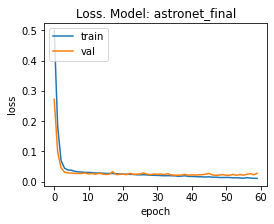

Fold 9:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  60
Epoch 1/60
164/164 [==============================] - 10s 53ms/step - loss: 0.4836 - precision_44: 0.0000e+00 - recall_44: 0.0000e+00 - binary_accuracy: 0.8421 - val_loss: 0.2818 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00 - val_binary_accuracy: 0.8419
Epoch 2/60
164/164 [==============================] - 8s 49ms/step - loss: 0.2081 - precision_44: 1.0000 - recall_44: 0.2376 - binary_accuracy: 0.8796 - val_loss: 0.1458 - val_precision_44: 0.9929 - val_recall_44: 0.7554 - val_binary_accuracy: 0.9605
Epoch 3/60
164/164 [============

Epoch 32/60
164/164 [==============================] - 8s 47ms/step - loss: 0.0165 - precision_44: 0.9878 - recall_44: 0.9825 - binary_accuracy: 0.9953 - val_loss: 0.0201 - val_precision_44: 0.9945 - val_recall_44: 0.9837 - val_binary_accuracy: 0.9966
Epoch 33/60
164/164 [==============================] - 8s 50ms/step - loss: 0.0161 - precision_44: 0.9854 - recall_44: 0.9813 - binary_accuracy: 0.9948 - val_loss: 0.0210 - val_precision_44: 0.9945 - val_recall_44: 0.9783 - val_binary_accuracy: 0.9957
Epoch 34/60
164/164 [==============================] - 8s 46ms/step - loss: 0.0163 - precision_44: 0.9854 - recall_44: 0.9800 - binary_accuracy: 0.9946 - val_loss: 0.0197 - val_precision_44: 0.9945 - val_recall_44: 0.9837 - val_binary_accuracy: 0.9966
Epoch 35/60
164/164 [==============================] - 8s 48ms/step - loss: 0.0156 - precision_44: 0.9884 - recall_44: 0.9831 - binary_accuracy: 0.9955 - val_loss: 0.0223 - val_precision_44: 0.9945 - val_recall_44: 0.9783 - val_binary_accuracy:

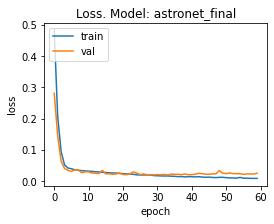

list n_epochs used:  [60, 60, 60, 60, 60, 60, 60, 60, 60, 60]
mean:  60.0


In [40]:
# CV astronet 10 folds, 60 eppchs (mean:  60.3)
CrossValidation("astronet_final", n_splits = 10, random_state = 95061385)

Fold 0:
10476
1165
data_train.shape[0]//2:  10476
data_validation.shape[0]//2:  1165
(10476, 4)
(1165, 4)
X_train_global.shape:  (10476, 201)
y_train.shape:  (10476, 1)
X_val_global.shape:  (1165, 201)
X_train_local.shape:  (10476, 61)
X_val_local.shape:  (1165, 61)
y_val.shape:  (1165, 1)
Epoch 1/292
164/164 [==============================] - 6s 34ms/step - loss: 0.6654 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - binary_accuracy: 0.8411 - val_loss: 0.6300 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - val_binary_accuracy: 0.8515
Epoch 2/292
164/164 [==============================] - 5s 30ms/step - loss: 0.5673 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - binary_accuracy: 0.8411 - val_loss: 0.4801 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - val_binary_accuracy: 0.8515
Epoch 3/292
164/164 [==============================] - 5s 32ms/step - loss: 0.4117 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - binary_accuracy: 0.8411 - val_loss: 0

164/164 [==============================] - 5s 31ms/step - loss: 0.1131 - precision_24: 0.8815 - recall_24: 0.8577 - binary_accuracy: 0.9590 - val_loss: 0.1118 - val_precision_24: 0.8675 - val_recall_24: 0.8324 - val_binary_accuracy: 0.9562
Epoch 64/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1130 - precision_24: 0.8798 - recall_24: 0.8619 - binary_accuracy: 0.9593 - val_loss: 0.1120 - val_precision_24: 0.8820 - val_recall_24: 0.8208 - val_binary_accuracy: 0.9571
Epoch 65/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1129 - precision_24: 0.8814 - recall_24: 0.8613 - binary_accuracy: 0.9595 - val_loss: 0.1123 - val_precision_24: 0.8981 - val_recall_24: 0.8150 - val_binary_accuracy: 0.9588
Epoch 66/292
164/164 [==============================] - 6s 34ms/step - loss: 0.1127 - precision_24: 0.8820 - recall_24: 0.8619 - binary_accuracy: 0.9597 - val_loss: 0.1124 - val_precision_24: 0.8981 - val_recall_24: 0.8150 - val_binary_accuracy: 0.9588
E

164/164 [==============================] - 6s 35ms/step - loss: 0.1059 - precision_24: 0.8866 - recall_24: 0.8691 - binary_accuracy: 0.9615 - val_loss: 0.1049 - val_precision_24: 0.8889 - val_recall_24: 0.8324 - val_binary_accuracy: 0.9597
Epoch 128/292
164/164 [==============================] - 6s 35ms/step - loss: 0.1059 - precision_24: 0.8862 - recall_24: 0.8703 - binary_accuracy: 0.9616 - val_loss: 0.1046 - val_precision_24: 0.8834 - val_recall_24: 0.8324 - val_binary_accuracy: 0.9588
Epoch 129/292
164/164 [==============================] - 6s 34ms/step - loss: 0.1058 - precision_24: 0.8862 - recall_24: 0.8697 - binary_accuracy: 0.9615 - val_loss: 0.1046 - val_precision_24: 0.8834 - val_recall_24: 0.8324 - val_binary_accuracy: 0.9588
Epoch 130/292
164/164 [==============================] - 5s 32ms/step - loss: 0.1059 - precision_24: 0.8869 - recall_24: 0.8715 - binary_accuracy: 0.9619 - val_loss: 0.1047 - val_precision_24: 0.8882 - val_recall_24: 0.8266 - val_binary_accuracy: 0.958

164/164 [==============================] - 5s 32ms/step - loss: 0.0997 - precision_24: 0.8951 - recall_24: 0.8811 - binary_accuracy: 0.9647 - val_loss: 0.0984 - val_precision_24: 0.8810 - val_recall_24: 0.8555 - val_binary_accuracy: 0.9614
Epoch 192/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0997 - precision_24: 0.8927 - recall_24: 0.8847 - binary_accuracy: 0.9648 - val_loss: 0.0985 - val_precision_24: 0.8902 - val_recall_24: 0.8439 - val_binary_accuracy: 0.9614
Epoch 193/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0996 - precision_24: 0.8927 - recall_24: 0.8793 - binary_accuracy: 0.9640 - val_loss: 0.0982 - val_precision_24: 0.8916 - val_recall_24: 0.8555 - val_binary_accuracy: 0.9631
Epoch 194/292
164/164 [==============================] - 5s 32ms/step - loss: 0.0994 - precision_24: 0.8944 - recall_24: 0.8847 - binary_accuracy: 0.9651 - val_loss: 0.0984 - val_precision_24: 0.8896 - val_recall_24: 0.8382 - val_binary_accuracy: 0.960

164/164 [==============================] - 5s 32ms/step - loss: 0.0922 - precision_24: 0.9089 - recall_24: 0.8925 - binary_accuracy: 0.9687 - val_loss: 0.0910 - val_precision_24: 0.8869 - val_recall_24: 0.8613 - val_binary_accuracy: 0.9631
Epoch 256/292
164/164 [==============================] - 5s 32ms/step - loss: 0.0919 - precision_24: 0.9047 - recall_24: 0.8955 - binary_accuracy: 0.9684 - val_loss: 0.0910 - val_precision_24: 0.8916 - val_recall_24: 0.8555 - val_binary_accuracy: 0.9631
Epoch 257/292
164/164 [==============================] - 5s 32ms/step - loss: 0.0918 - precision_24: 0.9094 - recall_24: 0.8925 - binary_accuracy: 0.9688 - val_loss: 0.0916 - val_precision_24: 0.9068 - val_recall_24: 0.8439 - val_binary_accuracy: 0.9639
Epoch 258/292
164/164 [==============================] - 5s 31ms/step - loss: 0.0917 - precision_24: 0.9101 - recall_24: 0.8877 - binary_accuracy: 0.9682 - val_loss: 0.0907 - val_precision_24: 0.8916 - val_recall_24: 0.8555 - val_binary_accuracy: 0.963

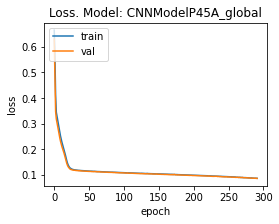

Fold 1:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
Epoch 1/292
164/164 [==============================] - 6s 33ms/step - loss: 0.6618 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - binary_accuracy: 0.8406 - val_loss: 0.6247 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00 - val_binary_accuracy: 0.8557
Epoch 2/292
164/164 [==============================] - 5s 31ms/step - loss: 0.5482 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - binary_accuracy: 0.8406 - val_loss: 0.4451 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00 - val_binary_accuracy: 0.8557
Epoch 3/292
164/164 [==============================] - 5s 31ms/step - loss: 0.3835 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - binary_accuracy: 0.8406 - val_loss: 0

164/164 [==============================] - 5s 32ms/step - loss: 0.1131 - precision_25: 0.8798 - recall_25: 0.8635 - binary_accuracy: 0.9594 - val_loss: 0.1051 - val_precision_25: 0.8439 - val_recall_25: 0.8690 - val_binary_accuracy: 0.9579
Epoch 64/292
164/164 [==============================] - 5s 32ms/step - loss: 0.1128 - precision_25: 0.8813 - recall_25: 0.8629 - binary_accuracy: 0.9596 - val_loss: 0.1040 - val_precision_25: 0.8538 - val_recall_25: 0.8690 - val_binary_accuracy: 0.9596
Epoch 65/292
164/164 [==============================] - 6s 34ms/step - loss: 0.1128 - precision_25: 0.8803 - recall_25: 0.8629 - binary_accuracy: 0.9594 - val_loss: 0.1052 - val_precision_25: 0.8457 - val_recall_25: 0.8810 - val_binary_accuracy: 0.9596
Epoch 66/292
164/164 [==============================] - 6s 34ms/step - loss: 0.1125 - precision_25: 0.8800 - recall_25: 0.8647 - binary_accuracy: 0.9596 - val_loss: 0.1037 - val_precision_25: 0.8538 - val_recall_25: 0.8690 - val_binary_accuracy: 0.9596
E

164/164 [==============================] - 5s 32ms/step - loss: 0.1052 - precision_25: 0.8887 - recall_25: 0.8701 - binary_accuracy: 0.9619 - val_loss: 0.0984 - val_precision_25: 0.8588 - val_recall_25: 0.9048 - val_binary_accuracy: 0.9648
Epoch 128/292
164/164 [==============================] - 5s 31ms/step - loss: 0.1052 - precision_25: 0.8873 - recall_25: 0.8725 - binary_accuracy: 0.9620 - val_loss: 0.0964 - val_precision_25: 0.8605 - val_recall_25: 0.8810 - val_binary_accuracy: 0.9622
Epoch 129/292
164/164 [==============================] - 5s 31ms/step - loss: 0.1051 - precision_25: 0.8886 - recall_25: 0.8737 - binary_accuracy: 0.9624 - val_loss: 0.0960 - val_precision_25: 0.8605 - val_recall_25: 0.8810 - val_binary_accuracy: 0.9622
Epoch 130/292
164/164 [==============================] - 5s 31ms/step - loss: 0.1049 - precision_25: 0.8868 - recall_25: 0.8725 - binary_accuracy: 0.9619 - val_loss: 0.0951 - val_precision_25: 0.8647 - val_recall_25: 0.8750 - val_binary_accuracy: 0.962

164/164 [==============================] - 5s 31ms/step - loss: 0.0987 - precision_25: 0.8970 - recall_25: 0.8808 - binary_accuracy: 0.9649 - val_loss: 0.0887 - val_precision_25: 0.8693 - val_recall_25: 0.9107 - val_binary_accuracy: 0.9674
Epoch 192/292
164/164 [==============================] - 5s 30ms/step - loss: 0.0985 - precision_25: 0.8973 - recall_25: 0.8838 - binary_accuracy: 0.9654 - val_loss: 0.0886 - val_precision_25: 0.8693 - val_recall_25: 0.9107 - val_binary_accuracy: 0.9674
Epoch 193/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0985 - precision_25: 0.8960 - recall_25: 0.8826 - binary_accuracy: 0.9650 - val_loss: 0.0876 - val_precision_25: 0.8786 - val_recall_25: 0.9048 - val_binary_accuracy: 0.9682
Epoch 194/292
164/164 [==============================] - 5s 34ms/step - loss: 0.0985 - precision_25: 0.8966 - recall_25: 0.8826 - binary_accuracy: 0.9651 - val_loss: 0.0878 - val_precision_25: 0.8736 - val_recall_25: 0.9048 - val_binary_accuracy: 0.967

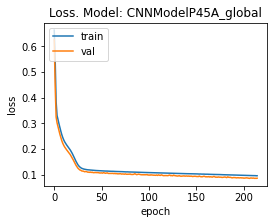

Fold 2:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
Epoch 1/292
164/164 [==============================] - 6s 35ms/step - loss: 0.6774 - precision_26: 0.1200 - recall_26: 0.1266 - binary_accuracy: 0.7133 - val_loss: 0.6466 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00 - val_binary_accuracy: 0.8531
Epoch 2/292
164/164 [==============================] - 6s 34ms/step - loss: 0.5889 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00 - binary_accuracy: 0.8409 - val_loss: 0.5036 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00 - val_binary_accuracy: 0.8531
Epoch 3/292
164/164 [==============================] - 6s 34ms/step - loss: 0.4306 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00 - binary_accuracy: 0.8409 - val_loss: 0.3588 - 

164/164 [==============================] - 6s 35ms/step - loss: 0.1085 - precision_26: 0.8880 - recall_26: 0.8656 - binary_accuracy: 0.9612 - val_loss: 0.1244 - val_precision_26: 0.8488 - val_recall_26: 0.8538 - val_binary_accuracy: 0.9562
Epoch 64/292
164/164 [==============================] - 6s 36ms/step - loss: 0.1083 - precision_26: 0.8877 - recall_26: 0.8632 - binary_accuracy: 0.9609 - val_loss: 0.1244 - val_precision_26: 0.8488 - val_recall_26: 0.8538 - val_binary_accuracy: 0.9562
Epoch 65/292
164/164 [==============================] - 6s 35ms/step - loss: 0.1083 - precision_26: 0.8857 - recall_26: 0.8650 - binary_accuracy: 0.9608 - val_loss: 0.1249 - val_precision_26: 0.8606 - val_recall_26: 0.8304 - val_binary_accuracy: 0.9553
Epoch 66/292
164/164 [==============================] - 6s 36ms/step - loss: 0.1081 - precision_26: 0.8876 - recall_26: 0.8620 - binary_accuracy: 0.9607 - val_loss: 0.1240 - val_precision_26: 0.8488 - val_recall_26: 0.8538 - val_binary_accuracy: 0.9562
E

164/164 [==============================] - 6s 35ms/step - loss: 0.1022 - precision_26: 0.8931 - recall_26: 0.8716 - binary_accuracy: 0.9630 - val_loss: 0.1177 - val_precision_26: 0.8555 - val_recall_26: 0.8655 - val_binary_accuracy: 0.9588
Epoch 128/292
164/164 [==============================] - 6s 36ms/step - loss: 0.1020 - precision_26: 0.8894 - recall_26: 0.8734 - binary_accuracy: 0.9626 - val_loss: 0.1179 - val_precision_26: 0.8596 - val_recall_26: 0.8596 - val_binary_accuracy: 0.9588
Epoch 129/292
164/164 [==============================] - 6s 35ms/step - loss: 0.1019 - precision_26: 0.8908 - recall_26: 0.8710 - binary_accuracy: 0.9625 - val_loss: 0.1173 - val_precision_26: 0.8506 - val_recall_26: 0.8655 - val_binary_accuracy: 0.9579
Epoch 130/292
164/164 [==============================] - 6s 37ms/step - loss: 0.1019 - precision_26: 0.8906 - recall_26: 0.8740 - binary_accuracy: 0.9629 - val_loss: 0.1178 - val_precision_26: 0.8647 - val_recall_26: 0.8596 - val_binary_accuracy: 0.959

164/164 [==============================] - 6s 36ms/step - loss: 0.0957 - precision_26: 0.9021 - recall_26: 0.8842 - binary_accuracy: 0.9663 - val_loss: 0.1108 - val_precision_26: 0.8605 - val_recall_26: 0.8655 - val_binary_accuracy: 0.9596
Epoch 192/292
164/164 [==============================] - 6s 35ms/step - loss: 0.0952 - precision_26: 0.9053 - recall_26: 0.8830 - binary_accuracy: 0.9667 - val_loss: 0.1106 - val_precision_26: 0.8506 - val_recall_26: 0.8655 - val_binary_accuracy: 0.9579
Epoch 193/292
164/164 [==============================] - 6s 37ms/step - loss: 0.0952 - precision_26: 0.8986 - recall_26: 0.8878 - binary_accuracy: 0.9662 - val_loss: 0.1109 - val_precision_26: 0.8706 - val_recall_26: 0.8655 - val_binary_accuracy: 0.9613
Epoch 194/292
164/164 [==============================] - 6s 35ms/step - loss: 0.0954 - precision_26: 0.9030 - recall_26: 0.8824 - binary_accuracy: 0.9662 - val_loss: 0.1103 - val_precision_26: 0.8555 - val_recall_26: 0.8655 - val_binary_accuracy: 0.958

164/164 [==============================] - 6s 36ms/step - loss: 0.0881 - precision_26: 0.9140 - recall_26: 0.8920 - binary_accuracy: 0.9695 - val_loss: 0.1023 - val_precision_26: 0.8772 - val_recall_26: 0.8772 - val_binary_accuracy: 0.9639
Epoch 256/292
164/164 [==============================] - 6s 37ms/step - loss: 0.0879 - precision_26: 0.9134 - recall_26: 0.8926 - binary_accuracy: 0.9695 - val_loss: 0.1025 - val_precision_26: 0.8810 - val_recall_26: 0.8655 - val_binary_accuracy: 0.9631
Epoch 257/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0880 - precision_26: 0.9109 - recall_26: 0.8950 - binary_accuracy: 0.9694 - val_loss: 0.1021 - val_precision_26: 0.8817 - val_recall_26: 0.8713 - val_binary_accuracy: 0.9639
Epoch 258/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0878 - precision_26: 0.9152 - recall_26: 0.8938 - binary_accuracy: 0.9699 - val_loss: 0.1020 - val_precision_26: 0.8817 - val_recall_26: 0.8713 - val_binary_accuracy: 0.963

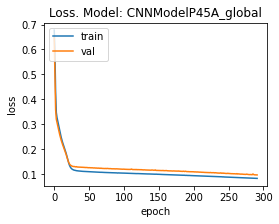

Fold 3:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
Epoch 1/292
164/164 [==============================] - 6s 36ms/step - loss: 0.6715 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00 - binary_accuracy: 0.8429 - val_loss: 0.6444 - val_precision_27: 0.0000e+00 - val_recall_27: 0.0000e+00 - val_binary_accuracy: 0.8351
Epoch 2/292
164/164 [==============================] - 6s 35ms/step - loss: 0.5896 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00 - binary_accuracy: 0.8429 - val_loss: 0.5182 - val_precision_27: 0.0000e+00 - val_recall_27: 0.0000e+00 - val_binary_accuracy: 0.8351
Epoch 3/292
164/164 [==============================] - 6s 35ms/step - loss: 0.4303 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00 - binary_accuracy: 0.8429 - val_loss: 0

164/164 [==============================] - 6s 34ms/step - loss: 0.1143 - precision_27: 0.8765 - recall_27: 0.8536 - binary_accuracy: 0.9581 - val_loss: 0.1103 - val_precision_27: 0.8947 - val_recall_27: 0.8854 - val_binary_accuracy: 0.9639
Epoch 64/292
164/164 [==============================] - 6s 34ms/step - loss: 0.1144 - precision_27: 0.8796 - recall_27: 0.8566 - binary_accuracy: 0.9591 - val_loss: 0.1102 - val_precision_27: 0.8947 - val_recall_27: 0.8854 - val_binary_accuracy: 0.9639
Epoch 65/292
164/164 [==============================] - 6s 36ms/step - loss: 0.1141 - precision_27: 0.8791 - recall_27: 0.8524 - binary_accuracy: 0.9584 - val_loss: 0.1105 - val_precision_27: 0.8854 - val_recall_27: 0.8854 - val_binary_accuracy: 0.9622
Epoch 66/292
164/164 [==============================] - 6s 36ms/step - loss: 0.1141 - precision_27: 0.8810 - recall_27: 0.8548 - binary_accuracy: 0.9591 - val_loss: 0.1100 - val_precision_27: 0.8854 - val_recall_27: 0.8854 - val_binary_accuracy: 0.9622
E

164/164 [==============================] - 5s 33ms/step - loss: 0.1052 - precision_27: 0.8875 - recall_27: 0.8627 - binary_accuracy: 0.9612 - val_loss: 0.1036 - val_precision_27: 0.8878 - val_recall_27: 0.9062 - val_binary_accuracy: 0.9656
Epoch 128/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1054 - precision_27: 0.8835 - recall_27: 0.8663 - binary_accuracy: 0.9611 - val_loss: 0.1025 - val_precision_27: 0.9194 - val_recall_27: 0.8906 - val_binary_accuracy: 0.9691
Epoch 129/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1051 - precision_27: 0.8844 - recall_27: 0.8645 - binary_accuracy: 0.9610 - val_loss: 0.1023 - val_precision_27: 0.9243 - val_recall_27: 0.8906 - val_binary_accuracy: 0.9699
Epoch 130/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1048 - precision_27: 0.8863 - recall_27: 0.8663 - binary_accuracy: 0.9615 - val_loss: 0.1027 - val_precision_27: 0.9101 - val_recall_27: 0.8958 - val_binary_accuracy: 0.968

164/164 [==============================] - 6s 34ms/step - loss: 0.0969 - precision_27: 0.8963 - recall_27: 0.8773 - binary_accuracy: 0.9648 - val_loss: 0.0966 - val_precision_27: 0.9175 - val_recall_27: 0.9271 - val_binary_accuracy: 0.9742
Epoch 192/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0969 - precision_27: 0.8909 - recall_27: 0.8785 - binary_accuracy: 0.9640 - val_loss: 0.0959 - val_precision_27: 0.9255 - val_recall_27: 0.9062 - val_binary_accuracy: 0.9725
Epoch 193/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0968 - precision_27: 0.8979 - recall_27: 0.8767 - binary_accuracy: 0.9650 - val_loss: 0.0955 - val_precision_27: 0.9344 - val_recall_27: 0.8906 - val_binary_accuracy: 0.9716
Epoch 194/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0966 - precision_27: 0.9003 - recall_27: 0.8718 - binary_accuracy: 0.9647 - val_loss: 0.0972 - val_precision_27: 0.9175 - val_recall_27: 0.9271 - val_binary_accuracy: 0.974

164/164 [==============================] - 5s 33ms/step - loss: 0.0882 - precision_27: 0.9073 - recall_27: 0.8864 - binary_accuracy: 0.9679 - val_loss: 0.0883 - val_precision_27: 0.9556 - val_recall_27: 0.8958 - val_binary_accuracy: 0.9759
Epoch 256/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0879 - precision_27: 0.9136 - recall_27: 0.8864 - binary_accuracy: 0.9690 - val_loss: 0.0884 - val_precision_27: 0.9516 - val_recall_27: 0.9219 - val_binary_accuracy: 0.9794
Epoch 257/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0877 - precision_27: 0.9097 - recall_27: 0.8876 - binary_accuracy: 0.9685 - val_loss: 0.0878 - val_precision_27: 0.9514 - val_recall_27: 0.9167 - val_binary_accuracy: 0.9785
Epoch 258/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0876 - precision_27: 0.9098 - recall_27: 0.8888 - binary_accuracy: 0.9687 - val_loss: 0.0881 - val_precision_27: 0.9516 - val_recall_27: 0.9219 - val_binary_accuracy: 0.979

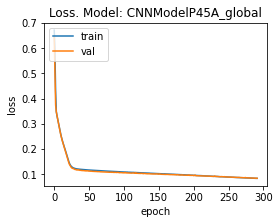

Fold 4:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
Epoch 1/292
164/164 [==============================] - 6s 34ms/step - loss: 0.6711 - precision_28: 0.7561 - recall_28: 0.0188 - binary_accuracy: 0.8445 - val_loss: 0.6406 - val_precision_28: 0.0000e+00 - val_recall_28: 0.0000e+00 - val_binary_accuracy: 0.8385
Epoch 2/292
164/164 [==============================] - 5s 31ms/step - loss: 0.5843 - precision_28: 0.0000e+00 - recall_28: 0.0000e+00 - binary_accuracy: 0.8425 - val_loss: 0.5124 - val_precision_28: 0.0000e+00 - val_recall_28: 0.0000e+00 - val_binary_accuracy: 0.8385
Epoch 3/292
164/164 [==============================] - 5s 31ms/step - loss: 0.4337 - precision_28: 0.0000e+00 - recall_28: 0.0000e+00 - binary_accuracy: 0.8425 - val_loss: 0.3747 - 

164/164 [==============================] - 6s 34ms/step - loss: 0.1093 - precision_28: 0.8845 - recall_28: 0.8636 - binary_accuracy: 0.9608 - val_loss: 0.1214 - val_precision_28: 0.8743 - val_recall_28: 0.8511 - val_binary_accuracy: 0.9562
Epoch 64/292
164/164 [==============================] - 6s 35ms/step - loss: 0.1093 - precision_28: 0.8800 - recall_28: 0.8709 - binary_accuracy: 0.9610 - val_loss: 0.1213 - val_precision_28: 0.8778 - val_recall_28: 0.8404 - val_binary_accuracy: 0.9553
Epoch 65/292
164/164 [==============================] - 6s 35ms/step - loss: 0.1092 - precision_28: 0.8839 - recall_28: 0.8624 - binary_accuracy: 0.9605 - val_loss: 0.1210 - val_precision_28: 0.8729 - val_recall_28: 0.8404 - val_binary_accuracy: 0.9545
Epoch 66/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1091 - precision_28: 0.8816 - recall_28: 0.8661 - binary_accuracy: 0.9606 - val_loss: 0.1211 - val_precision_28: 0.8820 - val_recall_28: 0.8351 - val_binary_accuracy: 0.9553
E

164/164 [==============================] - 5s 32ms/step - loss: 0.1014 - precision_28: 0.8949 - recall_28: 0.8770 - binary_accuracy: 0.9644 - val_loss: 0.1133 - val_precision_28: 0.8833 - val_recall_28: 0.8457 - val_binary_accuracy: 0.9570
Epoch 128/292
164/164 [==============================] - 5s 32ms/step - loss: 0.1014 - precision_28: 0.8949 - recall_28: 0.8776 - binary_accuracy: 0.9645 - val_loss: 0.1134 - val_precision_28: 0.8883 - val_recall_28: 0.8457 - val_binary_accuracy: 0.9579
Epoch 129/292
164/164 [==============================] - 5s 31ms/step - loss: 0.1011 - precision_28: 0.8958 - recall_28: 0.8752 - binary_accuracy: 0.9643 - val_loss: 0.1131 - val_precision_28: 0.8883 - val_recall_28: 0.8457 - val_binary_accuracy: 0.9579
Epoch 130/292
164/164 [==============================] - 5s 32ms/step - loss: 0.1010 - precision_28: 0.8947 - recall_28: 0.8758 - binary_accuracy: 0.9642 - val_loss: 0.1129 - val_precision_28: 0.8883 - val_recall_28: 0.8457 - val_binary_accuracy: 0.957

164/164 [==============================] - 6s 34ms/step - loss: 0.0925 - precision_28: 0.9097 - recall_28: 0.8848 - binary_accuracy: 0.9680 - val_loss: 0.1038 - val_precision_28: 0.8994 - val_recall_28: 0.8564 - val_binary_accuracy: 0.9613
Epoch 192/292
164/164 [==============================] - 6s 36ms/step - loss: 0.0924 - precision_28: 0.9054 - recall_28: 0.8873 - binary_accuracy: 0.9676 - val_loss: 0.1035 - val_precision_28: 0.8994 - val_recall_28: 0.8564 - val_binary_accuracy: 0.9613
Epoch 193/292
164/164 [==============================] - 6s 36ms/step - loss: 0.0922 - precision_28: 0.9086 - recall_28: 0.8861 - binary_accuracy: 0.9680 - val_loss: 0.1033 - val_precision_28: 0.8994 - val_recall_28: 0.8564 - val_binary_accuracy: 0.9613
Epoch 194/292
164/164 [==============================] - 6s 35ms/step - loss: 0.0920 - precision_28: 0.9090 - recall_28: 0.8897 - binary_accuracy: 0.9686 - val_loss: 0.1031 - val_precision_28: 0.8994 - val_recall_28: 0.8564 - val_binary_accuracy: 0.961

164/164 [==============================] - 5s 33ms/step - loss: 0.0816 - precision_28: 0.9225 - recall_28: 0.8939 - binary_accuracy: 0.9715 - val_loss: 0.0913 - val_precision_28: 0.9314 - val_recall_28: 0.8670 - val_binary_accuracy: 0.9682
Epoch 256/292
164/164 [==============================] - 5s 34ms/step - loss: 0.0814 - precision_28: 0.9250 - recall_28: 0.8970 - binary_accuracy: 0.9723 - val_loss: 0.0908 - val_precision_28: 0.8978 - val_recall_28: 0.8883 - val_binary_accuracy: 0.9656
Epoch 257/292
164/164 [==============================] - 5s 32ms/step - loss: 0.0812 - precision_28: 0.9215 - recall_28: 0.8964 - binary_accuracy: 0.9717 - val_loss: 0.0905 - val_precision_28: 0.9071 - val_recall_28: 0.8830 - val_binary_accuracy: 0.9665
Epoch 258/292
164/164 [==============================] - 5s 32ms/step - loss: 0.0814 - precision_28: 0.9244 - recall_28: 0.8970 - binary_accuracy: 0.9722 - val_loss: 0.0904 - val_precision_28: 0.9222 - val_recall_28: 0.8830 - val_binary_accuracy: 0.969

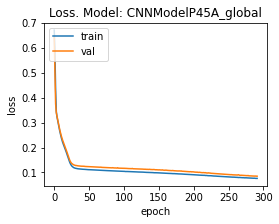

Fold 5:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
Epoch 1/292
164/164 [==============================] - 7s 36ms/step - loss: 0.6754 - precision_29: 0.0435 - recall_29: 6.0606e-04 - binary_accuracy: 0.8405 - val_loss: 0.6540 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00 - val_binary_accuracy: 0.8385
Epoch 2/292
164/164 [==============================] - 6s 35ms/step - loss: 0.6084 - precision_29: 0.0000e+00 - recall_29: 0.0000e+00 - binary_accuracy: 0.8425 - val_loss: 0.5432 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00 - val_binary_accuracy: 0.8385
Epoch 3/292
164/164 [==============================] - 6s 34ms/step - loss: 0.4559 - precision_29: 0.0000e+00 - recall_29: 0.0000e+00 - binary_accuracy: 0.8425 - val_loss: 0.383

164/164 [==============================] - 6s 34ms/step - loss: 0.1128 - precision_29: 0.8770 - recall_29: 0.8642 - binary_accuracy: 0.9595 - val_loss: 0.1101 - val_precision_29: 0.8710 - val_recall_29: 0.8617 - val_binary_accuracy: 0.9570
Epoch 64/292
164/164 [==============================] - 6s 35ms/step - loss: 0.1125 - precision_29: 0.8812 - recall_29: 0.8630 - binary_accuracy: 0.9601 - val_loss: 0.1097 - val_precision_29: 0.8804 - val_recall_29: 0.8617 - val_binary_accuracy: 0.9588
Epoch 65/292
164/164 [==============================] - 6s 35ms/step - loss: 0.1123 - precision_29: 0.8779 - recall_29: 0.8630 - binary_accuracy: 0.9595 - val_loss: 0.1091 - val_precision_29: 0.8798 - val_recall_29: 0.8564 - val_binary_accuracy: 0.9579
Epoch 66/292
164/164 [==============================] - 6s 35ms/step - loss: 0.1122 - precision_29: 0.8809 - recall_29: 0.8655 - binary_accuracy: 0.9604 - val_loss: 0.1089 - val_precision_29: 0.8846 - val_recall_29: 0.8564 - val_binary_accuracy: 0.9588
E

164/164 [==============================] - 6s 35ms/step - loss: 0.1025 - precision_29: 0.8899 - recall_29: 0.8715 - binary_accuracy: 0.9628 - val_loss: 0.1006 - val_precision_29: 0.9000 - val_recall_29: 0.8617 - val_binary_accuracy: 0.9622
Epoch 128/292
164/164 [==============================] - 6s 34ms/step - loss: 0.1022 - precision_29: 0.8897 - recall_29: 0.8752 - binary_accuracy: 0.9633 - val_loss: 0.1003 - val_precision_29: 0.9045 - val_recall_29: 0.8564 - val_binary_accuracy: 0.9622
Epoch 129/292
164/164 [==============================] - 6s 35ms/step - loss: 0.1022 - precision_29: 0.8877 - recall_29: 0.8721 - binary_accuracy: 0.9625 - val_loss: 0.1001 - val_precision_29: 0.9045 - val_recall_29: 0.8564 - val_binary_accuracy: 0.9622
Epoch 130/292
164/164 [==============================] - 6s 35ms/step - loss: 0.1020 - precision_29: 0.8907 - recall_29: 0.8745 - binary_accuracy: 0.9633 - val_loss: 0.1001 - val_precision_29: 0.9050 - val_recall_29: 0.8617 - val_binary_accuracy: 0.963

164/164 [==============================] - 6s 34ms/step - loss: 0.0904 - precision_29: 0.9054 - recall_29: 0.8879 - binary_accuracy: 0.9677 - val_loss: 0.0886 - val_precision_29: 0.9266 - val_recall_29: 0.8723 - val_binary_accuracy: 0.9682
Epoch 192/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0907 - precision_29: 0.9052 - recall_29: 0.8855 - binary_accuracy: 0.9674 - val_loss: 0.0897 - val_precision_29: 0.9130 - val_recall_29: 0.8936 - val_binary_accuracy: 0.9691
Epoch 193/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0901 - precision_29: 0.9083 - recall_29: 0.8885 - binary_accuracy: 0.9683 - val_loss: 0.0880 - val_precision_29: 0.9274 - val_recall_29: 0.8830 - val_binary_accuracy: 0.9699
Epoch 194/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0900 - precision_29: 0.9075 - recall_29: 0.8855 - binary_accuracy: 0.9677 - val_loss: 0.0884 - val_precision_29: 0.9227 - val_recall_29: 0.8883 - val_binary_accuracy: 0.969

164/164 [==============================] - 6s 35ms/step - loss: 0.0786 - precision_29: 0.9282 - recall_29: 0.9012 - binary_accuracy: 0.9735 - val_loss: 0.0792 - val_precision_29: 0.9010 - val_recall_29: 0.9202 - val_binary_accuracy: 0.9708
Epoch 256/292
164/164 [==============================] - 6s 35ms/step - loss: 0.0781 - precision_29: 0.9259 - recall_29: 0.9006 - binary_accuracy: 0.9730 - val_loss: 0.0755 - val_precision_29: 0.9435 - val_recall_29: 0.8883 - val_binary_accuracy: 0.9734
Epoch 257/292
164/164 [==============================] - 6s 35ms/step - loss: 0.0778 - precision_29: 0.9293 - recall_29: 0.9006 - binary_accuracy: 0.9736 - val_loss: 0.0755 - val_precision_29: 0.9438 - val_recall_29: 0.8936 - val_binary_accuracy: 0.9742
Epoch 258/292
164/164 [==============================] - 6s 35ms/step - loss: 0.0779 - precision_29: 0.9266 - recall_29: 0.9024 - binary_accuracy: 0.9734 - val_loss: 0.0754 - val_precision_29: 0.9389 - val_recall_29: 0.8989 - val_binary_accuracy: 0.974

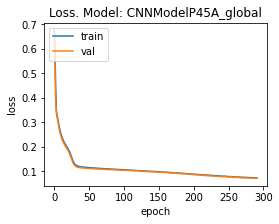

Fold 6:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
Epoch 1/292
164/164 [==============================] - 6s 34ms/step - loss: 0.6669 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - binary_accuracy: 0.8413 - val_loss: 0.6358 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_binary_accuracy: 0.8497
Epoch 2/292
164/164 [==============================] - 5s 33ms/step - loss: 0.5793 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - binary_accuracy: 0.8413 - val_loss: 0.4994 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00 - val_binary_accuracy: 0.8497
Epoch 3/292
164/164 [==============================] - 5s 32ms/step - loss: 0.4262 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - binary_accuracy: 0.8413 - val_loss: 0

164/164 [==============================] - 5s 33ms/step - loss: 0.1162 - precision_30: 0.8778 - recall_30: 0.8551 - binary_accuracy: 0.9581 - val_loss: 0.1071 - val_precision_30: 0.9036 - val_recall_30: 0.8571 - val_binary_accuracy: 0.9648
Epoch 64/292
164/164 [==============================] - 6s 34ms/step - loss: 0.1160 - precision_30: 0.8752 - recall_30: 0.8521 - binary_accuracy: 0.9572 - val_loss: 0.1069 - val_precision_30: 0.9036 - val_recall_30: 0.8571 - val_binary_accuracy: 0.9648
Epoch 65/292
164/164 [==============================] - 6s 34ms/step - loss: 0.1159 - precision_30: 0.8783 - recall_30: 0.8551 - binary_accuracy: 0.9582 - val_loss: 0.1067 - val_precision_30: 0.8988 - val_recall_30: 0.8629 - val_binary_accuracy: 0.9648
Epoch 66/292
164/164 [==============================] - 6s 34ms/step - loss: 0.1156 - precision_30: 0.8781 - recall_30: 0.8533 - binary_accuracy: 0.9579 - val_loss: 0.1067 - val_precision_30: 0.9036 - val_recall_30: 0.8571 - val_binary_accuracy: 0.9648
E

164/164 [==============================] - 5s 33ms/step - loss: 0.1065 - precision_30: 0.8835 - recall_30: 0.8665 - binary_accuracy: 0.9607 - val_loss: 0.0989 - val_precision_30: 0.9053 - val_recall_30: 0.8743 - val_binary_accuracy: 0.9674
Epoch 128/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1065 - precision_30: 0.8844 - recall_30: 0.8647 - binary_accuracy: 0.9606 - val_loss: 0.0989 - val_precision_30: 0.9048 - val_recall_30: 0.8686 - val_binary_accuracy: 0.9665
Epoch 129/292
164/164 [==============================] - 6s 34ms/step - loss: 0.1062 - precision_30: 0.8881 - recall_30: 0.8593 - binary_accuracy: 0.9605 - val_loss: 0.0990 - val_precision_30: 0.8960 - val_recall_30: 0.8857 - val_binary_accuracy: 0.9674
Epoch 130/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1061 - precision_30: 0.8866 - recall_30: 0.8653 - binary_accuracy: 0.9611 - val_loss: 0.0985 - val_precision_30: 0.9012 - val_recall_30: 0.8857 - val_binary_accuracy: 0.968

164/164 [==============================] - 5s 33ms/step - loss: 0.0956 - precision_30: 0.9026 - recall_30: 0.8803 - binary_accuracy: 0.9659 - val_loss: 0.0906 - val_precision_30: 0.9317 - val_recall_30: 0.8571 - val_binary_accuracy: 0.9691
Epoch 192/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0956 - precision_30: 0.9023 - recall_30: 0.8779 - binary_accuracy: 0.9655 - val_loss: 0.0893 - val_precision_30: 0.9176 - val_recall_30: 0.8914 - val_binary_accuracy: 0.9716
Epoch 193/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0955 - precision_30: 0.9045 - recall_30: 0.8827 - binary_accuracy: 0.9666 - val_loss: 0.0893 - val_precision_30: 0.9277 - val_recall_30: 0.8800 - val_binary_accuracy: 0.9716
Epoch 194/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0952 - precision_30: 0.9020 - recall_30: 0.8803 - binary_accuracy: 0.9658 - val_loss: 0.0890 - val_precision_30: 0.9281 - val_recall_30: 0.8857 - val_binary_accuracy: 0.972

164/164 [==============================] - 5s 33ms/step - loss: 0.0843 - precision_30: 0.9169 - recall_30: 0.8954 - binary_accuracy: 0.9705 - val_loss: 0.0787 - val_precision_30: 0.9290 - val_recall_30: 0.8971 - val_binary_accuracy: 0.9742
Epoch 256/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0840 - precision_30: 0.9169 - recall_30: 0.8960 - binary_accuracy: 0.9706 - val_loss: 0.0785 - val_precision_30: 0.9298 - val_recall_30: 0.9086 - val_binary_accuracy: 0.9759
Epoch 257/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0838 - precision_30: 0.9157 - recall_30: 0.8954 - binary_accuracy: 0.9703 - val_loss: 0.0784 - val_precision_30: 0.9290 - val_recall_30: 0.8971 - val_binary_accuracy: 0.9742
Epoch 258/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0837 - precision_30: 0.9167 - recall_30: 0.8936 - binary_accuracy: 0.9702 - val_loss: 0.0782 - val_precision_30: 0.9298 - val_recall_30: 0.9086 - val_binary_accuracy: 0.975

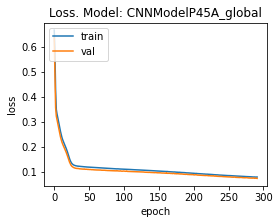

Fold 7:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
Epoch 1/292
164/164 [==============================] - 6s 34ms/step - loss: 0.6594 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - binary_accuracy: 0.8445 - val_loss: 0.6286 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_binary_accuracy: 0.8204
Epoch 2/292
164/164 [==============================] - 5s 32ms/step - loss: 0.5601 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - binary_accuracy: 0.8445 - val_loss: 0.4891 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00 - val_binary_accuracy: 0.8204
Epoch 3/292
164/164 [==============================] - 5s 32ms/step - loss: 0.3986 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - binary_accuracy: 0.8445 - val_loss: 0

164/164 [==============================] - 5s 32ms/step - loss: 0.1125 - precision_31: 0.8808 - recall_31: 0.8570 - binary_accuracy: 0.9597 - val_loss: 0.1109 - val_precision_31: 0.9086 - val_recall_31: 0.8565 - val_binary_accuracy: 0.9588
Epoch 64/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1124 - precision_31: 0.8805 - recall_31: 0.8551 - binary_accuracy: 0.9594 - val_loss: 0.1107 - val_precision_31: 0.9086 - val_recall_31: 0.8565 - val_binary_accuracy: 0.9588
Epoch 65/292
164/164 [==============================] - 5s 32ms/step - loss: 0.1122 - precision_31: 0.8782 - recall_31: 0.8539 - binary_accuracy: 0.9589 - val_loss: 0.1112 - val_precision_31: 0.9175 - val_recall_31: 0.8517 - val_binary_accuracy: 0.9596
Epoch 66/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1123 - precision_31: 0.8803 - recall_31: 0.8533 - binary_accuracy: 0.9591 - val_loss: 0.1095 - val_precision_31: 0.9005 - val_recall_31: 0.8660 - val_binary_accuracy: 0.9588
E

164/164 [==============================] - 6s 34ms/step - loss: 0.1031 - precision_31: 0.8911 - recall_31: 0.8686 - binary_accuracy: 0.9631 - val_loss: 0.1006 - val_precision_31: 0.9104 - val_recall_31: 0.8756 - val_binary_accuracy: 0.9622
Epoch 128/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1028 - precision_31: 0.8900 - recall_31: 0.8692 - binary_accuracy: 0.9630 - val_loss: 0.1002 - val_precision_31: 0.9024 - val_recall_31: 0.8852 - val_binary_accuracy: 0.9622
Epoch 129/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1029 - precision_31: 0.8897 - recall_31: 0.8662 - binary_accuracy: 0.9625 - val_loss: 0.0999 - val_precision_31: 0.8990 - val_recall_31: 0.8947 - val_binary_accuracy: 0.9631
Epoch 130/292
164/164 [==============================] - 6s 36ms/step - loss: 0.1025 - precision_31: 0.8900 - recall_31: 0.8692 - binary_accuracy: 0.9630 - val_loss: 0.1009 - val_precision_31: 0.9146 - val_recall_31: 0.8708 - val_binary_accuracy: 0.962

164/164 [==============================] - 6s 34ms/step - loss: 0.0940 - precision_31: 0.9065 - recall_31: 0.8809 - binary_accuracy: 0.9674 - val_loss: 0.0927 - val_precision_31: 0.9167 - val_recall_31: 0.8947 - val_binary_accuracy: 0.9665
Epoch 192/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0938 - precision_31: 0.9060 - recall_31: 0.8815 - binary_accuracy: 0.9674 - val_loss: 0.0921 - val_precision_31: 0.9126 - val_recall_31: 0.8995 - val_binary_accuracy: 0.9665
Epoch 193/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0936 - precision_31: 0.9048 - recall_31: 0.8809 - binary_accuracy: 0.9671 - val_loss: 0.0923 - val_precision_31: 0.9122 - val_recall_31: 0.8947 - val_binary_accuracy: 0.9656
Epoch 194/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0937 - precision_31: 0.9085 - recall_31: 0.8772 - binary_accuracy: 0.9672 - val_loss: 0.0918 - val_precision_31: 0.9126 - val_recall_31: 0.8995 - val_binary_accuracy: 0.966

164/164 [==============================] - 5s 33ms/step - loss: 0.0834 - precision_31: 0.9172 - recall_31: 0.8907 - binary_accuracy: 0.9705 - val_loss: 0.0828 - val_precision_31: 0.9403 - val_recall_31: 0.9043 - val_binary_accuracy: 0.9725
Epoch 256/292
164/164 [==============================] - 6s 34ms/step - loss: 0.0840 - precision_31: 0.9185 - recall_31: 0.8920 - binary_accuracy: 0.9709 - val_loss: 0.0827 - val_precision_31: 0.9403 - val_recall_31: 0.9043 - val_binary_accuracy: 0.9725
Epoch 257/292
164/164 [==============================] - 5s 32ms/step - loss: 0.0835 - precision_31: 0.9129 - recall_31: 0.8877 - binary_accuracy: 0.9694 - val_loss: 0.0823 - val_precision_31: 0.9403 - val_recall_31: 0.9043 - val_binary_accuracy: 0.9725
Epoch 258/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0830 - precision_31: 0.9177 - recall_31: 0.8895 - binary_accuracy: 0.9704 - val_loss: 0.0819 - val_precision_31: 0.9310 - val_recall_31: 0.9043 - val_binary_accuracy: 0.970

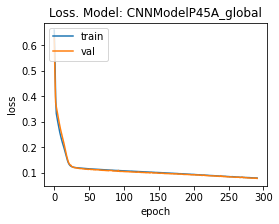

Fold 8:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
Epoch 1/292
164/164 [==============================] - 6s 33ms/step - loss: 0.6686 - precision_32: 0.1376 - recall_32: 0.0382 - binary_accuracy: 0.8110 - val_loss: 0.6335 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_binary_accuracy: 0.8368
Epoch 2/292
164/164 [==============================] - 5s 32ms/step - loss: 0.5641 - precision_32: 0.0000e+00 - recall_32: 0.0000e+00 - binary_accuracy: 0.8427 - val_loss: 0.4838 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00 - val_binary_accuracy: 0.8368
Epoch 3/292
164/164 [==============================] - 5s 32ms/step - loss: 0.4044 - precision_32: 0.0000e+00 - recall_32: 0.0000e+00 - binary_accuracy: 0.8427 - val_loss: 0.3612 - 

164/164 [==============================] - 5s 32ms/step - loss: 0.1132 - precision_32: 0.8760 - recall_32: 0.8574 - binary_accuracy: 0.9585 - val_loss: 0.1005 - val_precision_32: 0.8956 - val_recall_32: 0.8579 - val_binary_accuracy: 0.9605
Epoch 64/292
164/164 [==============================] - 6s 34ms/step - loss: 0.1133 - precision_32: 0.8828 - recall_32: 0.8544 - binary_accuracy: 0.9592 - val_loss: 0.1004 - val_precision_32: 0.8930 - val_recall_32: 0.8789 - val_binary_accuracy: 0.9631
Epoch 65/292
164/164 [==============================] - 5s 31ms/step - loss: 0.1131 - precision_32: 0.8775 - recall_32: 0.8562 - binary_accuracy: 0.9586 - val_loss: 0.1002 - val_precision_32: 0.8925 - val_recall_32: 0.8737 - val_binary_accuracy: 0.9622
Epoch 66/292
164/164 [==============================] - 5s 32ms/step - loss: 0.1128 - precision_32: 0.8817 - recall_32: 0.8550 - binary_accuracy: 0.9591 - val_loss: 0.1019 - val_precision_32: 0.8814 - val_recall_32: 0.9000 - val_binary_accuracy: 0.9639
E

164/164 [==============================] - 5s 32ms/step - loss: 0.1061 - precision_32: 0.8840 - recall_32: 0.8689 - binary_accuracy: 0.9614 - val_loss: 0.0932 - val_precision_32: 0.8947 - val_recall_32: 0.8947 - val_binary_accuracy: 0.9656
Epoch 128/292
164/164 [==============================] - 5s 32ms/step - loss: 0.1060 - precision_32: 0.8850 - recall_32: 0.8635 - binary_accuracy: 0.9609 - val_loss: 0.0931 - val_precision_32: 0.8947 - val_recall_32: 0.8947 - val_binary_accuracy: 0.9656
Epoch 129/292
164/164 [==============================] - 5s 33ms/step - loss: 0.1060 - precision_32: 0.8834 - recall_32: 0.8689 - binary_accuracy: 0.9613 - val_loss: 0.0928 - val_precision_32: 0.9066 - val_recall_32: 0.8684 - val_binary_accuracy: 0.9639
Epoch 130/292
164/164 [==============================] - 5s 32ms/step - loss: 0.1057 - precision_32: 0.8887 - recall_32: 0.8623 - binary_accuracy: 0.9613 - val_loss: 0.0929 - val_precision_32: 0.8947 - val_recall_32: 0.8947 - val_binary_accuracy: 0.965

164/164 [==============================] - 5s 32ms/step - loss: 0.0980 - precision_32: 0.8973 - recall_32: 0.8799 - binary_accuracy: 0.9653 - val_loss: 0.0858 - val_precision_32: 0.9116 - val_recall_32: 0.8684 - val_binary_accuracy: 0.9648
Epoch 192/292
164/164 [==============================] - 5s 32ms/step - loss: 0.0981 - precision_32: 0.9001 - recall_32: 0.8750 - binary_accuracy: 0.9651 - val_loss: 0.0856 - val_precision_32: 0.9000 - val_recall_32: 0.9000 - val_binary_accuracy: 0.9674
Epoch 193/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0979 - precision_32: 0.8967 - recall_32: 0.8799 - binary_accuracy: 0.9652 - val_loss: 0.0858 - val_precision_32: 0.8969 - val_recall_32: 0.9158 - val_binary_accuracy: 0.9691
Epoch 194/292
164/164 [==============================] - 5s 32ms/step - loss: 0.0977 - precision_32: 0.8994 - recall_32: 0.8786 - binary_accuracy: 0.9654 - val_loss: 0.0852 - val_precision_32: 0.9130 - val_recall_32: 0.8842 - val_binary_accuracy: 0.967

164/164 [==============================] - 5s 32ms/step - loss: 0.0869 - precision_32: 0.9156 - recall_32: 0.8883 - binary_accuracy: 0.9696 - val_loss: 0.0762 - val_precision_32: 0.9149 - val_recall_32: 0.9053 - val_binary_accuracy: 0.9708
Epoch 256/292
164/164 [==============================] - 5s 33ms/step - loss: 0.0864 - precision_32: 0.9178 - recall_32: 0.8877 - binary_accuracy: 0.9698 - val_loss: 0.0764 - val_precision_32: 0.9062 - val_recall_32: 0.9158 - val_binary_accuracy: 0.9708
Epoch 257/292
164/164 [==============================] - 5s 32ms/step - loss: 0.0863 - precision_32: 0.9153 - recall_32: 0.8920 - binary_accuracy: 0.9700 - val_loss: 0.0760 - val_precision_32: 0.9101 - val_recall_32: 0.9053 - val_binary_accuracy: 0.9699
Epoch 258/292
164/164 [==============================] - 5s 32ms/step - loss: 0.0862 - precision_32: 0.9166 - recall_32: 0.8938 - binary_accuracy: 0.9705 - val_loss: 0.0760 - val_precision_32: 0.9062 - val_recall_32: 0.9158 - val_binary_accuracy: 0.970

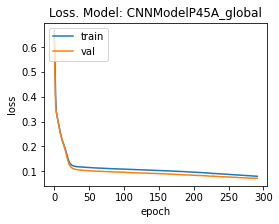

Fold 9:
10477
1164
data_train.shape[0]//2:  10477
data_validation.shape[0]//2:  1164
(10477, 4)
(1164, 4)
X_train_global.shape:  (10477, 201)
y_train.shape:  (10477, 1)
X_val_global.shape:  (1164, 201)
X_train_local.shape:  (10477, 61)
X_val_local.shape:  (1164, 61)
y_val.shape:  (1164, 1)
Epoch 1/292
164/164 [==============================] - 7s 38ms/step - loss: 0.6749 - precision_33: 0.0327 - recall_33: 0.0060 - binary_accuracy: 0.8148 - val_loss: 0.6502 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00 - val_binary_accuracy: 0.8419
Epoch 2/292
164/164 [==============================] - 6s 37ms/step - loss: 0.5990 - precision_33: 0.0000e+00 - recall_33: 0.0000e+00 - binary_accuracy: 0.8421 - val_loss: 0.5253 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00 - val_binary_accuracy: 0.8419
Epoch 3/292
164/164 [==============================] - 6s 37ms/step - loss: 0.4369 - precision_33: 0.0000e+00 - recall_33: 0.0000e+00 - binary_accuracy: 0.8421 - val_loss: 0.3657 - 

164/164 [==============================] - 6s 37ms/step - loss: 0.1121 - precision_33: 0.8834 - recall_33: 0.8609 - binary_accuracy: 0.9601 - val_loss: 0.1253 - val_precision_33: 0.8708 - val_recall_33: 0.8424 - val_binary_accuracy: 0.9553
Epoch 64/292
164/164 [==============================] - 6s 37ms/step - loss: 0.1121 - precision_33: 0.8821 - recall_33: 0.8591 - binary_accuracy: 0.9596 - val_loss: 0.1251 - val_precision_33: 0.8708 - val_recall_33: 0.8424 - val_binary_accuracy: 0.9553
Epoch 65/292
164/164 [==============================] - 6s 37ms/step - loss: 0.1117 - precision_33: 0.8821 - recall_33: 0.8597 - binary_accuracy: 0.9597 - val_loss: 0.1257 - val_precision_33: 0.8750 - val_recall_33: 0.8370 - val_binary_accuracy: 0.9553
Epoch 66/292
164/164 [==============================] - 6s 37ms/step - loss: 0.1114 - precision_33: 0.8845 - recall_33: 0.8519 - binary_accuracy: 0.9591 - val_loss: 0.1254 - val_precision_33: 0.8495 - val_recall_33: 0.8587 - val_binary_accuracy: 0.9536
E

164/164 [==============================] - 7s 40ms/step - loss: 0.1036 - precision_33: 0.8882 - recall_33: 0.8694 - binary_accuracy: 0.9621 - val_loss: 0.1169 - val_precision_33: 0.8764 - val_recall_33: 0.8478 - val_binary_accuracy: 0.9570
Epoch 128/292
164/164 [==============================] - 7s 40ms/step - loss: 0.1035 - precision_33: 0.8890 - recall_33: 0.8712 - binary_accuracy: 0.9625 - val_loss: 0.1169 - val_precision_33: 0.8764 - val_recall_33: 0.8478 - val_binary_accuracy: 0.9570
Epoch 129/292
164/164 [==============================] - 7s 41ms/step - loss: 0.1034 - precision_33: 0.8893 - recall_33: 0.8694 - binary_accuracy: 0.9623 - val_loss: 0.1163 - val_precision_33: 0.8634 - val_recall_33: 0.8587 - val_binary_accuracy: 0.9562
Epoch 130/292
164/164 [==============================] - 7s 40ms/step - loss: 0.1034 - precision_33: 0.8887 - recall_33: 0.8736 - binary_accuracy: 0.9628 - val_loss: 0.1166 - val_precision_33: 0.8764 - val_recall_33: 0.8478 - val_binary_accuracy: 0.957

164/164 [==============================] - 6s 37ms/step - loss: 0.0937 - precision_33: 0.9052 - recall_33: 0.8833 - binary_accuracy: 0.9670 - val_loss: 0.1054 - val_precision_33: 0.8791 - val_recall_33: 0.8696 - val_binary_accuracy: 0.9605
Epoch 192/292
164/164 [==============================] - 6s 37ms/step - loss: 0.0936 - precision_33: 0.9022 - recall_33: 0.8869 - binary_accuracy: 0.9670 - val_loss: 0.1058 - val_precision_33: 0.9040 - val_recall_33: 0.8696 - val_binary_accuracy: 0.9648
Epoch 193/292
164/164 [==============================] - 6s 37ms/step - loss: 0.0934 - precision_33: 0.9038 - recall_33: 0.8803 - binary_accuracy: 0.9663 - val_loss: 0.1052 - val_precision_33: 0.8939 - val_recall_33: 0.8696 - val_binary_accuracy: 0.9631
Epoch 194/292
164/164 [==============================] - 6s 37ms/step - loss: 0.0932 - precision_33: 0.9051 - recall_33: 0.8875 - binary_accuracy: 0.9675 - val_loss: 0.1055 - val_precision_33: 0.9091 - val_recall_33: 0.8696 - val_binary_accuracy: 0.965

164/164 [==============================] - 6s 38ms/step - loss: 0.0815 - precision_33: 0.9229 - recall_33: 0.8972 - binary_accuracy: 0.9719 - val_loss: 0.0905 - val_precision_33: 0.9153 - val_recall_33: 0.8804 - val_binary_accuracy: 0.9682
Epoch 256/292
164/164 [==============================] - 6s 38ms/step - loss: 0.0812 - precision_33: 0.9174 - recall_33: 0.9002 - binary_accuracy: 0.9715 - val_loss: 0.0937 - val_precision_33: 0.9412 - val_recall_33: 0.8696 - val_binary_accuracy: 0.9708
Epoch 257/292
164/164 [==============================] - 6s 38ms/step - loss: 0.0811 - precision_33: 0.9241 - recall_33: 0.8984 - binary_accuracy: 0.9723 - val_loss: 0.0921 - val_precision_33: 0.9249 - val_recall_33: 0.8696 - val_binary_accuracy: 0.9682
Epoch 258/292
164/164 [==============================] - 6s 38ms/step - loss: 0.0810 - precision_33: 0.9227 - recall_33: 0.8954 - binary_accuracy: 0.9717 - val_loss: 0.0899 - val_precision_33: 0.9153 - val_recall_33: 0.8804 - val_binary_accuracy: 0.968

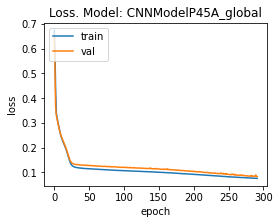

list n_epochs used:  [292, 215, 292, 292, 292, 292, 292, 292, 292, 292]
mean:  284.3


In [30]:
CrossValidation("CNNModelP45A_global", n_splits = 10, random_state = 95061385)

---------------------------------------------------
Model name: models/astronet_fold_0.h5
37/37 [==============================] - 1s 12ms/step
Model Accuracy (Validation set):  0.9957081545064378
AUC-ROC (Validation set): 0.9994464385605072

Confusion Matrix



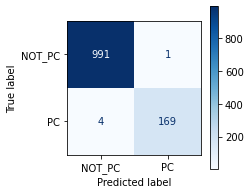

              precision    recall  f1-score   support

      NOT_PC       1.00      1.00      1.00       992
          PC       0.99      0.98      0.99       173

    accuracy                           1.00      1165
   macro avg       1.00      0.99      0.99      1165
weighted avg       1.00      1.00      1.00      1165



---------------------------------------------------
Model name: models/astronet_fold_1.h5
37/37 [==============================] - 1s 11ms/step
Model Accuracy (Validation set):  0.9957044673539519
AUC-ROC (Validation set): 0.9996473991202907

Confusion Matrix



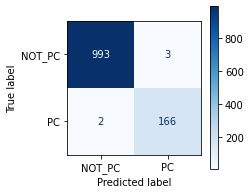

              precision    recall  f1-score   support

      NOT_PC       1.00      1.00      1.00       996
          PC       0.98      0.99      0.99       168

    accuracy                           1.00      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       1.00      1.00      1.00      1164



---------------------------------------------------
Model name: models/astronet_fold_2.h5
37/37 [==============================] - 1s 11ms/step
Model Accuracy (Validation set):  0.9905498281786942
AUC-ROC (Validation set): 0.9986808242492772

Confusion Matrix



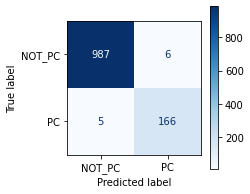

              precision    recall  f1-score   support

      NOT_PC       0.99      0.99      0.99       993
          PC       0.97      0.97      0.97       171

    accuracy                           0.99      1164
   macro avg       0.98      0.98      0.98      1164
weighted avg       0.99      0.99      0.99      1164



---------------------------------------------------
Model name: models/astronet_fold_3.h5
37/37 [==============================] - 1s 10ms/step
Model Accuracy (Validation set):  0.993127147766323
AUC-ROC (Validation set): 0.9988050840192044

Confusion Matrix



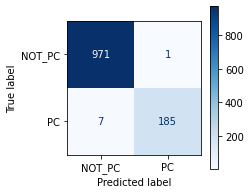

              precision    recall  f1-score   support

      NOT_PC       0.99      1.00      1.00       972
          PC       0.99      0.96      0.98       192

    accuracy                           0.99      1164
   macro avg       0.99      0.98      0.99      1164
weighted avg       0.99      0.99      0.99      1164



---------------------------------------------------
Model name: models/astronet_fold_4.h5
37/37 [==============================] - 1s 12ms/step
Model Accuracy (Validation set):  0.9948453608247423
AUC-ROC (Validation set): 0.9990626089989535

Confusion Matrix



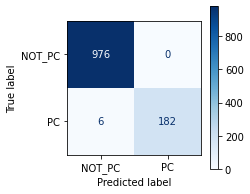

              precision    recall  f1-score   support

      NOT_PC       0.99      1.00      1.00       976
          PC       1.00      0.97      0.98       188

    accuracy                           0.99      1164
   macro avg       1.00      0.98      0.99      1164
weighted avg       0.99      0.99      0.99      1164



---------------------------------------------------
Model name: models/astronet_fold_5.h5
37/37 [==============================] - 1s 12ms/step
Model Accuracy (Validation set):  0.9957044673539519
AUC-ROC (Validation set): 0.9999346006278339

Confusion Matrix



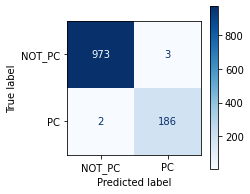

              precision    recall  f1-score   support

      NOT_PC       1.00      1.00      1.00       976
          PC       0.98      0.99      0.99       188

    accuracy                           1.00      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       1.00      1.00      1.00      1164



---------------------------------------------------
Model name: models/astronet_fold_6.h5
37/37 [==============================] - 1s 11ms/step
Model Accuracy (Validation set):  0.9965635738831615
AUC-ROC (Validation set): 0.9977813086812075

Confusion Matrix



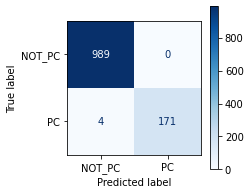

              precision    recall  f1-score   support

      NOT_PC       1.00      1.00      1.00       989
          PC       1.00      0.98      0.99       175

    accuracy                           1.00      1164
   macro avg       1.00      0.99      0.99      1164
weighted avg       1.00      1.00      1.00      1164



---------------------------------------------------
Model name: models/astronet_fold_7.h5
37/37 [==============================] - 1s 11ms/step
Model Accuracy (Validation set):  0.9948453608247423
AUC-ROC (Validation set): 0.9999148275257397

Confusion Matrix



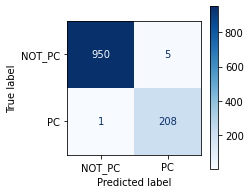

              precision    recall  f1-score   support

      NOT_PC       1.00      0.99      1.00       955
          PC       0.98      1.00      0.99       209

    accuracy                           0.99      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       0.99      0.99      0.99      1164



---------------------------------------------------
Model name: models/astronet_fold_8.h5
37/37 [==============================] - 1s 10ms/step
Model Accuracy (Validation set):  0.993127147766323
AUC-ROC (Validation set): 0.9995893223819301

Confusion Matrix



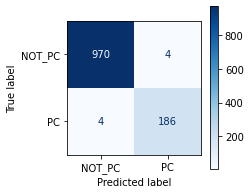

              precision    recall  f1-score   support

      NOT_PC       1.00      1.00      1.00       974
          PC       0.98      0.98      0.98       190

    accuracy                           0.99      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       0.99      0.99      0.99      1164



---------------------------------------------------
Model name: models/astronet_fold_9.h5
37/37 [==============================] - 1s 10ms/step
Model Accuracy (Validation set):  0.9965635738831615
AUC-ROC (Validation set): 0.9985913930789707

Confusion Matrix



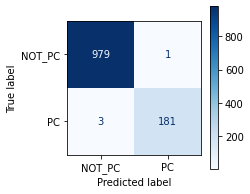

              precision    recall  f1-score   support

      NOT_PC       1.00      1.00      1.00       980
          PC       0.99      0.98      0.99       184

    accuracy                           1.00      1164
   macro avg       1.00      0.99      0.99      1164
weighted avg       1.00      1.00      1.00      1164



------------------------------------
Mean PC precision:  0.9870211771402404
Mean NOT_PC precision:  0.9961369312678323
Mean PC recall:  0.9791723748650043
Mean NOT_PC recall:  0.9975472227704222
Mean auc_roc:  0.9991453807243914
------------------------------------


In [34]:
CrossValidation_visualization("astronet", 10)


---------------------------------------------------
Model name: models/astronet_final_fold_0.h5
37/37 [==============================] - 1s 12ms/step
Model Accuracy (Validation set):  0.9939914163090129
AUC-ROC (Validation set): 0.9993590341226926

Confusion Matrix



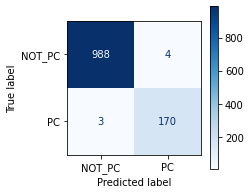

              precision    recall  f1-score   support

      NOT_PC       1.00      1.00      1.00       992
          PC       0.98      0.98      0.98       173

    accuracy                           0.99      1165
   macro avg       0.99      0.99      0.99      1165
weighted avg       0.99      0.99      0.99      1165



---------------------------------------------------
Model name: models/astronet_final_fold_1.h5
37/37 [==============================] - 1s 10ms/step
Model Accuracy (Validation set):  0.9965635738831615
AUC-ROC (Validation set): 0.9997131382673552

Confusion Matrix



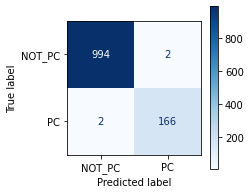

              precision    recall  f1-score   support

      NOT_PC       1.00      1.00      1.00       996
          PC       0.99      0.99      0.99       168

    accuracy                           1.00      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       1.00      1.00      1.00      1164



---------------------------------------------------
Model name: models/astronet_final_fold_2.h5
37/37 [==============================] - 1s 9ms/step
Model Accuracy (Validation set):  0.9905498281786942
AUC-ROC (Validation set): 0.9992991878824284

Confusion Matrix



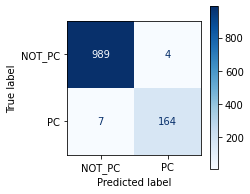

              precision    recall  f1-score   support

      NOT_PC       0.99      1.00      0.99       993
          PC       0.98      0.96      0.97       171

    accuracy                           0.99      1164
   macro avg       0.98      0.98      0.98      1164
weighted avg       0.99      0.99      0.99      1164



---------------------------------------------------
Model name: models/astronet_final_fold_3.h5
37/37 [==============================] - 1s 15ms/step
Model Accuracy (Validation set):  0.9939862542955327
AUC-ROC (Validation set): 0.9993087705761318

Confusion Matrix



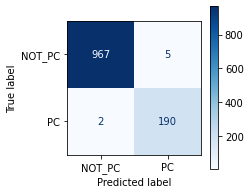

              precision    recall  f1-score   support

      NOT_PC       1.00      0.99      1.00       972
          PC       0.97      0.99      0.98       192

    accuracy                           0.99      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       0.99      0.99      0.99      1164



---------------------------------------------------
Model name: models/astronet_final_fold_4.h5
37/37 [==============================] - 1s 15ms/step
Model Accuracy (Validation set):  0.9948453608247423
AUC-ROC (Validation set): 0.9992424572724102

Confusion Matrix



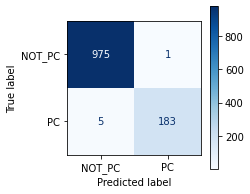

              precision    recall  f1-score   support

      NOT_PC       0.99      1.00      1.00       976
          PC       0.99      0.97      0.98       188

    accuracy                           0.99      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       0.99      0.99      0.99      1164



---------------------------------------------------
Model name: models/astronet_final_fold_5.h5
37/37 [==============================] - 1s 14ms/step
Model Accuracy (Validation set):  0.9957044673539519
AUC-ROC (Validation set): 0.9998964509940704

Confusion Matrix



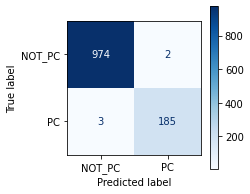

              precision    recall  f1-score   support

      NOT_PC       1.00      1.00      1.00       976
          PC       0.99      0.98      0.99       188

    accuracy                           1.00      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       1.00      1.00      1.00      1164



---------------------------------------------------
Model name: models/astronet_final_fold_6.h5
37/37 [==============================] - 1s 14ms/step
Model Accuracy (Validation set):  0.9957044673539519
AUC-ROC (Validation set): 0.9986364292936588

Confusion Matrix



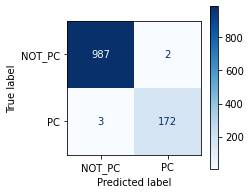

              precision    recall  f1-score   support

      NOT_PC       1.00      1.00      1.00       989
          PC       0.99      0.98      0.99       175

    accuracy                           1.00      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       1.00      1.00      1.00      1164



---------------------------------------------------
Model name: models/astronet_final_fold_7.h5
37/37 [==============================] - 1s 13ms/step
Model Accuracy (Validation set):  0.9948453608247423
AUC-ROC (Validation set): 0.999889776798016

Confusion Matrix



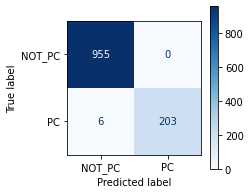

              precision    recall  f1-score   support

      NOT_PC       0.99      1.00      1.00       955
          PC       1.00      0.97      0.99       209

    accuracy                           0.99      1164
   macro avg       1.00      0.99      0.99      1164
weighted avg       0.99      0.99      0.99      1164



---------------------------------------------------
Model name: models/astronet_final_fold_8.h5
37/37 [==============================] - 1s 12ms/step
Model Accuracy (Validation set):  0.9922680412371134
AUC-ROC (Validation set): 0.9996433589106236

Confusion Matrix



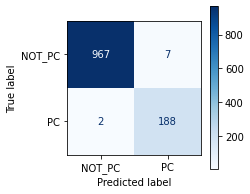

              precision    recall  f1-score   support

      NOT_PC       1.00      0.99      1.00       974
          PC       0.96      0.99      0.98       190

    accuracy                           0.99      1164
   macro avg       0.98      0.99      0.99      1164
weighted avg       0.99      0.99      0.99      1164



---------------------------------------------------
Model name: models/astronet_final_fold_9.h5
37/37 [==============================] - 1s 11ms/step
Model Accuracy (Validation set):  0.9948453608247423
AUC-ROC (Validation set): 0.9975876220053238

Confusion Matrix



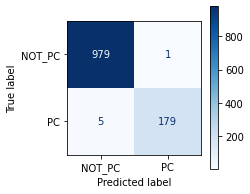

              precision    recall  f1-score   support

      NOT_PC       0.99      1.00      1.00       980
          PC       0.99      0.97      0.98       184

    accuracy                           0.99      1164
   macro avg       0.99      0.99      0.99      1164
weighted avg       0.99      0.99      0.99      1164



------------------------------------
Mean PC precision:  0.9846578968796535
Mean NOT_PC precision:  0.9961280877860675
Mean PC recall:  0.979329744701506
Mean NOT_PC recall:  0.9971484197840589
Mean auc_roc:  0.9992576226122709
------------------------------------


In [41]:
CrossValidation_visualization("astronet_final", 10)


---------------------------------------------------
Model name: models/CNNModelP45A_global_fold_0.h5
37/37 [==============================] - 0s 6ms/step
Model Accuracy (Validation set):  0.9665236051502146
AUC-ROC (Validation set): 0.9902165299272795

Confusion Matrix



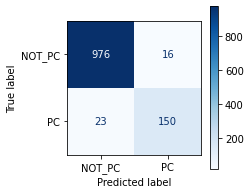

              precision    recall  f1-score   support

      NOT_PC       0.98      0.98      0.98       992
          PC       0.90      0.87      0.88       173

    accuracy                           0.97      1165
   macro avg       0.94      0.93      0.93      1165
weighted avg       0.97      0.97      0.97      1165



---------------------------------------------------
Model name: models/CNNModelP45A_global_fold_1.h5
37/37 [==============================] - 0s 6ms/step
Model Accuracy (Validation set):  0.9699312714776632
AUC-ROC (Validation set): 0.9904618473895583

Confusion Matrix



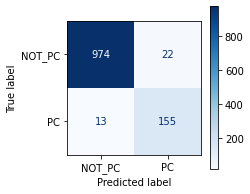

              precision    recall  f1-score   support

      NOT_PC       0.99      0.98      0.98       996
          PC       0.88      0.92      0.90       168

    accuracy                           0.97      1164
   macro avg       0.93      0.95      0.94      1164
weighted avg       0.97      0.97      0.97      1164



---------------------------------------------------
Model name: models/CNNModelP45A_global_fold_2.h5
37/37 [==============================] - 0s 6ms/step
Model Accuracy (Validation set):  0.9656357388316151
AUC-ROC (Validation set): 0.9864077784255872

Confusion Matrix



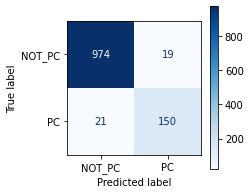

              precision    recall  f1-score   support

      NOT_PC       0.98      0.98      0.98       993
          PC       0.89      0.88      0.88       171

    accuracy                           0.97      1164
   macro avg       0.93      0.93      0.93      1164
weighted avg       0.97      0.97      0.97      1164



---------------------------------------------------
Model name: models/CNNModelP45A_global_fold_3.h5
37/37 [==============================] - 0s 6ms/step
Model Accuracy (Validation set):  0.9802405498281787
AUC-ROC (Validation set): 0.9869041495198903

Confusion Matrix



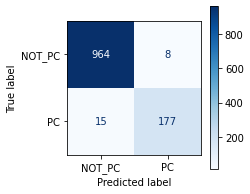

              precision    recall  f1-score   support

      NOT_PC       0.98      0.99      0.99       972
          PC       0.96      0.92      0.94       192

    accuracy                           0.98      1164
   macro avg       0.97      0.96      0.96      1164
weighted avg       0.98      0.98      0.98      1164



---------------------------------------------------
Model name: models/CNNModelP45A_global_fold_4.h5
37/37 [==============================] - 0s 6ms/step
Model Accuracy (Validation set):  0.9690721649484536
AUC-ROC (Validation set): 0.9887458580397629

Confusion Matrix



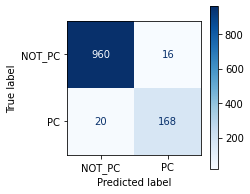

              precision    recall  f1-score   support

      NOT_PC       0.98      0.98      0.98       976
          PC       0.91      0.89      0.90       188

    accuracy                           0.97      1164
   macro avg       0.95      0.94      0.94      1164
weighted avg       0.97      0.97      0.97      1164



---------------------------------------------------
Model name: models/CNNModelP45A_global_fold_5.h5
37/37 [==============================] - 0s 5ms/step
Model Accuracy (Validation set):  0.9759450171821306
AUC-ROC (Validation set): 0.9928115190094176

Confusion Matrix



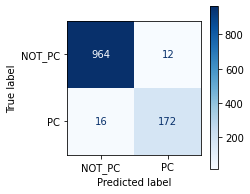

              precision    recall  f1-score   support

      NOT_PC       0.98      0.99      0.99       976
          PC       0.93      0.91      0.92       188

    accuracy                           0.98      1164
   macro avg       0.96      0.95      0.96      1164
weighted avg       0.98      0.98      0.98      1164



---------------------------------------------------
Model name: models/CNNModelP45A_global_fold_6.h5
37/37 [==============================] - 0s 6ms/step
Model Accuracy (Validation set):  0.9768041237113402
AUC-ROC (Validation set): 0.9912234580384227

Confusion Matrix



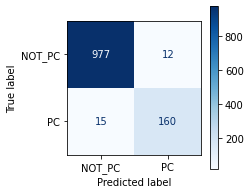

              precision    recall  f1-score   support

      NOT_PC       0.98      0.99      0.99       989
          PC       0.93      0.91      0.92       175

    accuracy                           0.98      1164
   macro avg       0.96      0.95      0.95      1164
weighted avg       0.98      0.98      0.98      1164



---------------------------------------------------
Model name: models/CNNModelP45A_global_fold_7.h5
37/37 [==============================] - 0s 6ms/step
Model Accuracy (Validation set):  0.9699312714776632
AUC-ROC (Validation set): 0.9934667702096746

Confusion Matrix



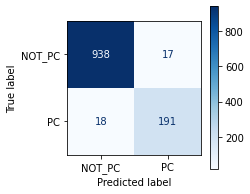

              precision    recall  f1-score   support

      NOT_PC       0.98      0.98      0.98       955
          PC       0.92      0.91      0.92       209

    accuracy                           0.97      1164
   macro avg       0.95      0.95      0.95      1164
weighted avg       0.97      0.97      0.97      1164



---------------------------------------------------
Model name: models/CNNModelP45A_global_fold_8.h5
37/37 [==============================] - 0s 6ms/step
Model Accuracy (Validation set):  0.9742268041237113
AUC-ROC (Validation set): 0.9934723873338377

Confusion Matrix



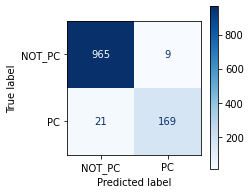

              precision    recall  f1-score   support

      NOT_PC       0.98      0.99      0.98       974
          PC       0.95      0.89      0.92       190

    accuracy                           0.97      1164
   macro avg       0.96      0.94      0.95      1164
weighted avg       0.97      0.97      0.97      1164



---------------------------------------------------
Model name: models/CNNModelP45A_global_fold_9.h5
37/37 [==============================] - 0s 6ms/step
Model Accuracy (Validation set):  0.9707903780068728
AUC-ROC (Validation set): 0.9906333185448093

Confusion Matrix



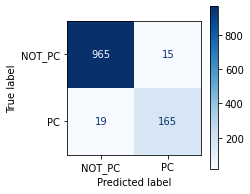

              precision    recall  f1-score   support

      NOT_PC       0.98      0.98      0.98       980
          PC       0.92      0.90      0.91       184

    accuracy                           0.97      1164
   macro avg       0.95      0.94      0.94      1164
weighted avg       0.97      0.97      0.97      1164



------------------------------------
Mean PC precision:  0.9186084138553532
Mean NOT_PC precision:  0.9816087235472859
Mean PC recall:  0.9011623818511596
Mean NOT_PC recall:  0.9851248815374664
Mean auc_roc:  0.990434361643824
------------------------------------


In [36]:
CrossValidation_visualization("CNNModelP45A_global", 10, only_global = True)

### Train with all

Used with the best model after CV (astronet_final).

In [43]:
_batch_size = 70 # Numero de ejemplos por gradient update.

train_size = int(1.0*np.unique(data_train_full_util["index"]).shape[0])

n_mini_batchs = int(np.ceil(train_size / _batch_size)) 

print("Train size: ", train_size)
print(f"Número de mini-batch por epoch: {n_mini_batchs}")


Train size:  11641
Número de mini-batch por epoch: 167


In [44]:
def TrainAll_Astronet_Final(random_state = 95061385):
    
    model_name = "astronet_final"

    folder = "GeneratedSamples"

    unique_indexs = np.unique(data_train_full_util["index"]).copy()
    np.random.seed(random_state)
    np.random.shuffle(unique_indexs)
    
    XY = [] # train set
    for idx in unique_indexs:
        data_local, data_global, info = get_example(idx, folder, data_train_full_util, only_info = False)

        if (info['label'] == 'PC'):
            label = 1
        else:
            label = 0
        XY.append([idx, data_global[1, :], data_local[1, :],  label])
    
    XY = np.array(XY, dtype=object)
    print("XY.shape: ", XY.shape)
    
    X_train_global = np.stack(XY[:,1])
    X_train_local = np.stack(XY[:,2])
    y_train = XY[:,3].reshape((-1,1)).astype('float32')
    
    print("X_train_global.shape: ", X_train_global.shape)
    print("y_train.shape: ",y_train.shape)
    
    _batch_size = 70
    batch_size = _batch_size 
    learning_rate = 1e-05
    st = time.time()
    
    n_epochs = 60
    model = astronetTriageCNN(name = 'Astronet-Triage', num_pre_logits_hidden_layers = 4,pre_logits_hidden_layer_size= 512, output_dim = 1, 
                        input_shape_g=(201,1), activation_func_g='relu', 
                        cnn_num_blocks_g=5, cnn_initial_num_filters_g=16, cnn_block_filter_factor_g=2, cnn_block_size_g=2, 
                        cnn_kernel_size_g=5, convolution_padding_g='same', pool_size_g=5, pool_strides_g=2,
                        input_shape_l=(61,1), activation_func_l='relu', cnn_num_blocks_l=2, 
                        cnn_initial_num_filters_l=16, cnn_block_filter_factor_l=2, cnn_block_size_l=2, cnn_kernel_size_l=5,
                        convolution_padding_l='same', pool_size_l=7, pool_strides_l=2)

    st = time.time()
    model.compile( loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(),
                    keras.metrics.BinaryAccuracy()], optimizer=tf.optimizers.Adam(learning_rate))

    print("n_epochs: ", n_epochs)
    history = model.fit(
        x = [X_train_global, X_train_local],
        y = y_train,
        batch_size=_batch_size,
        epochs=n_epochs,
        verbose=1,
    )
    
    et = time.time()
    print(f'Execution time: {et - st} seconds')
    
    fig = plt.figure(figsize=(4, 3))    
    plt.plot(history.history['loss'])
    plt.title(f'Loss. Model: {model_name}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    model.save(f'models/FINAL_{model_name}.h5')         

XY.shape:  (11641, 4)
X_train_global.shape:  (11641, 201)
y_train.shape:  (11641, 1)
block_1
block_2
block_3
block_4
block_5
NET_SHAPE:  [None, 3, 256]
OUTPUT_DIM:  768
block_1
block_2
NET_SHAPE:  [None, 11, 32]
OUTPUT_DIM:  352
n_epochs:  60
Epoch 1/60
167/167 [==============================] - 11s 55ms/step - loss: 0.4687 - precision_45: 0.0000e+00 - recall_45: 0.0000e+00 - binary_accuracy: 0.8411
Epoch 2/60
167/167 [==============================] - 9s 55ms/step - loss: 0.0916 - precision_45: 0.9809 - recall_45: 0.8085 - binary_accuracy: 0.9673
Epoch 3/60
167/167 [==============================] - 9s 55ms/step - loss: 0.0410 - precision_45: 0.9723 - recall_45: 0.9532 - binary_accuracy: 0.9883
Epoch 4/60
167/167 [==============================] - 9s 55ms/step - loss: 0.0382 - precision_45: 0.9749 - recall_45: 0.9527 - binary_accuracy: 0.9887
Epoch 5/60
167/167 [==============================] - 9s 55ms/step - loss: 0.0355 - precision_45: 0.9750 - recall_45: 0.9565 - binary_accuracy: 

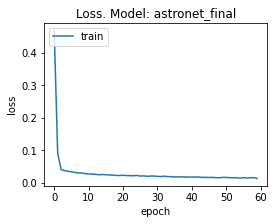

In [45]:
TrainAll_Astronet_Final()

# Load final model

In [46]:
final_model = keras.models.load_model(f'models/FINAL_astronet_final.h5')
final_model.summary()

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_global (InputLayer)      [(None, 201, 1)]     0           []                               
                                                                                                  
 conv1d_504 (Conv1D)            (None, 201, 16)      96          ['Input_global[0][0]']           
                                                                                                  
 conv1d_505 (Conv1D)            (None, 201, 16)      1296        ['conv1d_504[0][0]']             
                                                                                                  
 max_pooling1d_252 (MaxPooling1  (None, 99, 16)      0           ['conv1d_505[0][0]']             
 D)                                                                                        

### Test set

In [48]:
data_test_full = pd.read_csv('csv/data_test_full.csv')
data_test_full.shape[0]//4

1029

In [49]:
# check balance
print(data_test_full[data_test_full["label"] == "PC"].shape[0]//4)
print(data_test_full[data_test_full["label"] == "NOT_PC"].shape[0]//3)

236
1058


In [51]:
data_test_without_label = pd.read_csv('csv/data_test_without_label.csv')

In [52]:
def get_example(index, folder, only_info = False):
    
    query_index = data_test_without_label[data_test_without_label["index"] == index]
    local_filename = query_index[query_index["view"] == "Local"]["filename"].values[0]
    global_filename = query_index[query_index["view"] == "Global"]["filename"].values[0]
    
    if (only_info):
        return info
    else:
        data_global = np.load(f"{folder}/{global_filename}")
        data_local = np.load(f"{folder}/{local_filename}")

        return data_local, data_global, _

In [53]:
data_test_without_label

,target,satellite,index,filename,view,n_points_transit
0,HD102249,BHr,97,97_global_HD102249_BHr.npy,Global,3322
1,HD102249,BHr,97,97_local_HD102249_BHr.npy,Local,3322
2,HD102776,BTr,361,361_global_HD102776_BTr.npy,Global,8113
3,HD102776,BTr,361,361_local_HD102776_BTr.npy,Local,8113
4,HD102776,BTr,362,362_global_HD102776_BTr.npy,Global,8113
...,...,...,...,...,...,...
2583,HD93194,BHr,21215,21215_local_HD93194_BHr.npy,Local,4724
2584,HD93194,BHr,21216,21216_global_HD93194_BHr.npy,Global,4724
2585,HD93194,BHr,21216,21216_local_HD93194_BHr.npy,Local,4724
2586,HD93194,BHr,21218,21218_global_HD93194_BHr.npy,Global,4724


In [61]:

folder = "GeneratedSamples"
predictions = []
predictions_value = []
true_label = []
for index in np.unique(data_test_without_label["index"]):
    #print(index)
    data_local, data_global, _ = get_example(index, folder)
    
    prediction = final_model.predict( [data_global[1,:].reshape(1,-1), data_local[1,:].reshape(1,-1)] )[0][0][0]
    
    if (prediction >= 0.5):
        predictions.append('PC')
    else:
        predictions.append('NOT_PC')
        
    predictions_value.append(prediction)
        
    true_label.append(data_test_full[data_test_full['index'] == index]['label'].values[0])
    
    

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


In [63]:
print(len(predictions))
print(len(true_label))
print(len(predictions_value))

1294
1294
1294


In [66]:

true_label_ = []
predictions_ = []

for p in predictions:
    if (p == 'PC'):
        predictions_.append(1)
    else:
        predictions_.append(0)
        
for l in true_label:
    if (l == 'PC'):
        true_label_.append(1)
    else:
        true_label_.append(0)

In [70]:


np.set_printoptions(precision=2)
report = classification_report(true_label, predictions,  output_dict = True)
auc_roc = roc_auc_score(true_label_, predictions_value) 
report

{'NOT_PC': {'precision': 0.9962157048249763,
  'recall': 0.995274102079395,
  'f1-score': 0.9957446808510637,
  'support': 1058},
 'PC': {'precision': 0.9789029535864979,
  'recall': 0.9830508474576272,
  'f1-score': 0.9809725158562369,
  'support': 236},
 'accuracy': 0.9930448222565688,
 'macro avg': {'precision': 0.9875593292057372,
  'recall': 0.989162474768511,
  'f1-score': 0.9883585983536503,
  'support': 1294},
 'weighted avg': {'precision': 0.9930582015079122,
  'recall': 0.9930448222565688,
  'f1-score': 0.9930505302028573,
  'support': 1294}}

In [76]:
#

In [71]:
    
print("------------------------------------")
print("PC precision: ", report['PC']['precision'])
print("NOT_PC precision: ", report['NOT_PC']['precision'])
print("PC recall: ",  report['PC']['recall'])
print("NOT_PC recall: ", report['NOT_PC']['recall'])
print("auc_roc: ", auc_roc)
print("------------------------------------")


------------------------------------
PC precision:  0.9789029535864979
NOT_PC precision:  0.9962157048249763
PC recall:  0.9830508474576272
NOT_PC recall:  0.995274102079395
auc_roc:  0.9991229053859216
------------------------------------


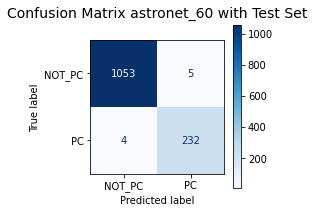

In [78]:
target_names = ["NOT_PC", "PC"]

fig, ax = plt.subplots(figsize=(3, 3))
cm = confusion_matrix(true_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.title('Confusion Matrix astronet_60 with Test Set\n', size = 14)
plt.show()
